## main notebook

- `main_notebook.ipynb` (thisone) is for visualising the results. 
- `sacred_ex.py` contains the experiment configuration (parameter settings) and simulation.
- `SimulationClass.py` contains the code for the simulation with `Nest`.

In [244]:
# nest
import nest
import nest.raster_plot
import nest.voltage_trace
# other
import os
import json
import time # to track how long simulation takes
import timeit
import itertools
import numpy as np
from importlib import reload # to reload the module when making changes
from itertools import permutations # for creating the permutations
from itertools import combinations 
import matplotlib.pyplot as plt
import seaborn as sns
# horay for beautiful plots
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("white")
# set the path 
path = 'data/'

import SimulationClass as simu
# update changes made in python script
reload(simu)

# === Sacred imports === 
import sacred_ex as experiment
reload(experiment) # update if any changes were made

# import the experiment from .py to run here
from sacred_ex import ex

import json
import os
from pprint import pprint

### How to run an experiment

Run the experiment directly from Python with the [run object](https://sacred.readthedocs.io/en/stable/apidoc.html#the-run-object). 

Can pass in the following arguments for `ex.run`:

- `config_updates`. Changes to the configuration as a nested dictionary (`config_updates={'g_L': 16.5}`)

### Collected information

This is a summary from [here](https://sacred.readthedocs.io/en/stable/collected_information.html)

- **Configuration** - sacred collects the final configuration. It also keeps track of information about what changes have occurred and whether they are suspicious. Suspicious changes include adding configuration entries that are not used anywhere, or typechanges of existing entries.
    - acces through `r.config` and `r.config_modifications`

- **Experiment info** - includes name and base directory of the experiment, list of source files, list of dependencies and optionally a list about its git repo.
    - acces through `r.experiment_info`
    
- **Host info**
- **Boookkeeping**
- **Return values of the main function** - `r.result`

... and more

### Observing an experiment

Capture the variables I want to use for visualisation

- do this by adding an [observer](https://sacred.readthedocs.io/en/stable/observers.html), by attaching an observer you can gather all the information about the run even while its still running. I am using the `File Storage Observer`.

        
### Get info directly from run object

```
# get the configuration info
r.config

# get all experiment info
r.experiment_info

# meta information
r.meta_info
```

## 1 Run a number of experiments

In [245]:
# run the experiment
r = ex.run(config_updates={'g_L':16.5})

INFO - testing_sacred - Running command 'run'
INFO - testing_sacred - Started run with ID "11"
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

INFO - testing_sacred - Completed after 0:00:38


## 2 Each experiment is stored in the folder

[Directory Structure](https://sacred.readthedocs.io/en/stable/observers.html#directory-structure)
The File storage observer makes a separate sub-directory for each run and stores several files in there:
- one folder contains `config.json` (params), `cout.txt` (captured output), `run.json` (main information) and `info.json` (saving custom info and artifacts)
- one folder named `_sources` that contains a snapshot of the source code


## 3 Query the database and visualise results

- choose an experiment by index
- get neural results
- get parameters for plotting

In [246]:
# choose experiment that want to query data from
idx = 11

# check if path exists
os.path.isdir(f'my_runs/{idx}/')

True

In [247]:
with open(f'my_runs/{idx}/run.json') as json_file:
    data = json.load(json_file)

# get spike data
spike_times_lst, spike_neurons_lst = data['result']['py/tuple']

# convert to numpy arrays
spike_times_arr = np.array([np.array(i) for i in spike_times_lst])
spike_neurons_arr = np.array([np.array(i) for i in spike_times_lst])

In [248]:
with open(f'my_runs/{idx}/config.json') as json_file:
    params = json.load(json_file)
    
neuron_params = params['neuron_params']
sim_params = params['sim_params']

# initialise classes
udp = simu.UpDownPatterns(sim_params, neuron_params)
H = simu.HelperFuncs()

In [249]:
# convert to numpy arrays
spike_times_arr = np.array([np.array(i) for i in spike_times_lst])
spike_neurons_arr = np.array([np.array(i) for i in spike_times_lst])

In [250]:
num_transient_spikes_arr = []
time_transient_spikes_arr = []
transient_duration_arr = []
unique_active_neurons = []

# cutoff point: when no current was injected anymore
stim_end

for trial in range(len(spike_times_arr)):
    
    # select data from experiment / trial
    times = spike_times_arr[trial]
    neurons = spike_neurons_arr[trial]
    
    # get amount of spikes in transient for that trial
    num_trans_spikes = sum(1*(times > stim_end))
    num_transient_spikes_arr.append(num_trans_spikes)
    
    # select the spiketimes after the stimulation ended
    time_transient_spikes = times[times > stim_end]
    time_transient_spikes_arr.append(time_transient_spikes)
    
    # get the length of the transient
    if num_trans_spikes == 0:
        transient_duration_arr.append(0)
    else:
        t_dur = round(max(time_transient_spikes_arr[trial]) - stim_end,2)
        transient_duration_arr.append(t_dur)
        
    # get the number of unique active neurons per transient
    transients = 1*(times > stim_end)
    transient_indices = np.argwhere(transients)
    # take the neurons from these indices
    active_neurons = np.unique(neurons[transient_indices])
    unique_active_neurons.append(active_neurons)

## 5. Data analysis

### 5.1.1 What is the distribution of the number of spikes per transient?

- the blue line is the KDE, set `kde=False` to display the number of trials. Note to self - [review this](https://mathisonian.github.io/kde/) 

- KDE: a technique that let’s you create a smooth curve given a set of data.
This can be useful if you want to visualize just the “shape” of some data, as a kind of continuous replacement for the discrete histogram.

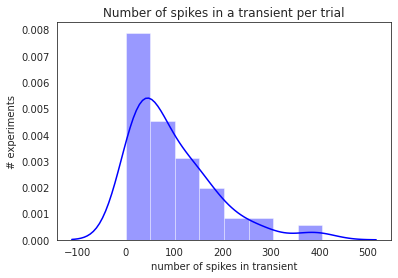

In [251]:
sns.distplot(num_transient_spikes_arr,color='b', kde=True)
plt.title('Number of spikes in a transient per trial')
plt.xlabel('number of spikes in transient')
plt.ylabel('# experiments');

### 5.1.2 What is the distribution of the transient durations?

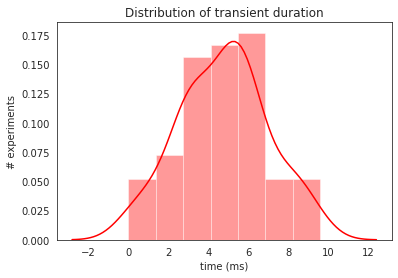

In [252]:
sns.distplot(transient_duration_arr ,color='r', kde=True)
plt.title('Distribution of transient duration')
plt.xlabel('time (ms)')
plt.ylabel('# experiments');

### 5.1.3 How many (unique) neurons are active in given transient?

In [253]:
total_active_neurons = [len(i) for i in unique_active_neurons]

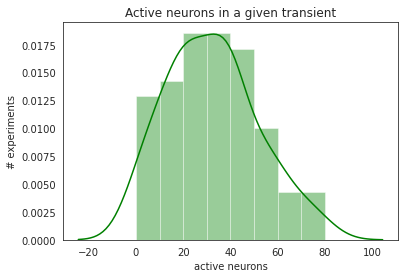

In [254]:
sns.distplot(total_active_neurons ,color='g', kde=True)
plt.title('Active neurons in a given transient')
plt.xlabel('active neurons')
plt.ylabel('# experiments');

- perform analysis to find out if the data follows a specific distribution

### Power law distribution tests

paper: https://arxiv.org/abs/0706.1062

https://github.com/xiaoylu/check-if-power-law

scipy power law: https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.powerlaw.html


### Other distributions

In [255]:
patterns = []
# make permutations for 8 bit pattern
for perm in H.make_permutations():
    patterns.append(perm)

/home/nest/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


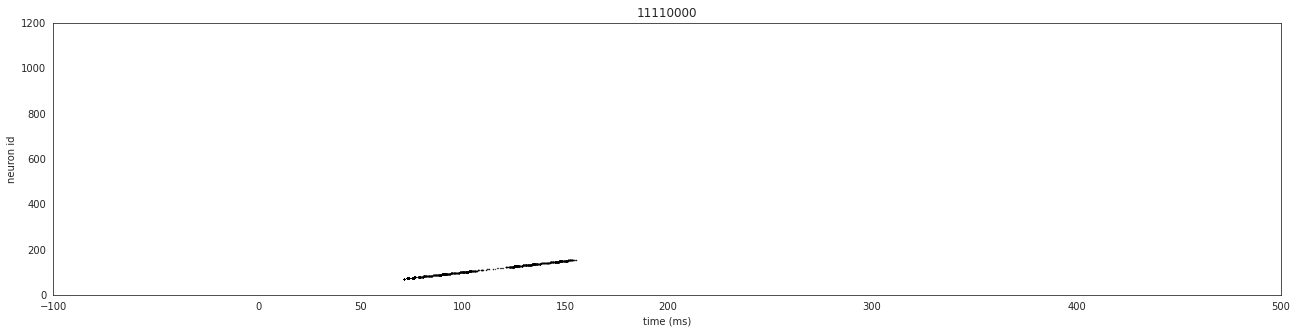

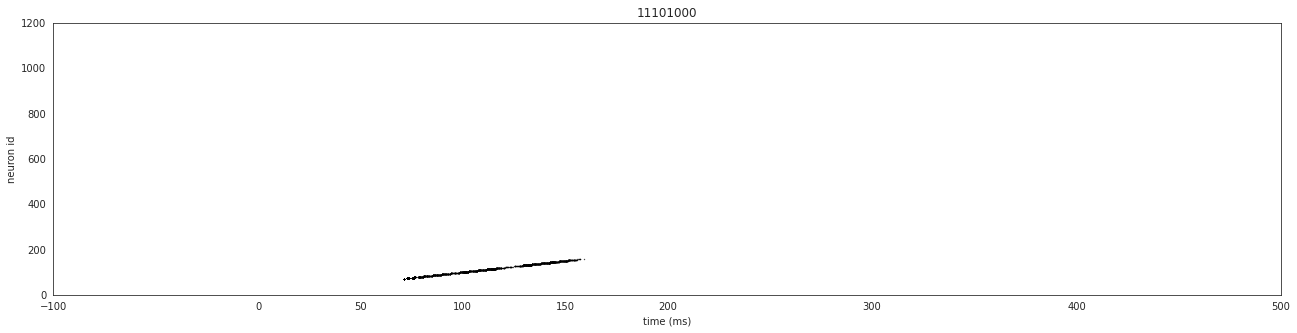

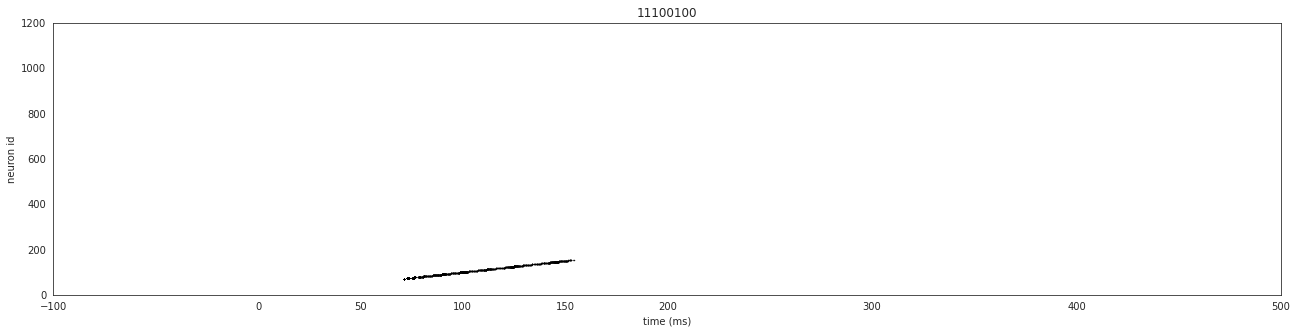

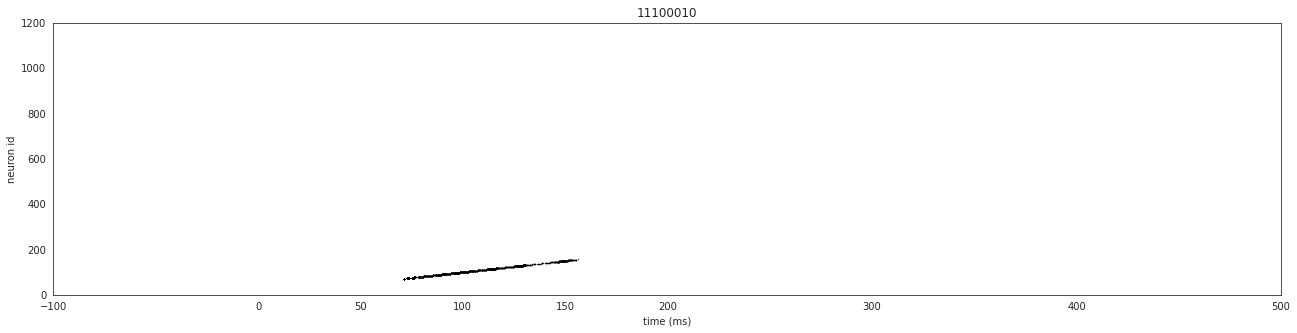

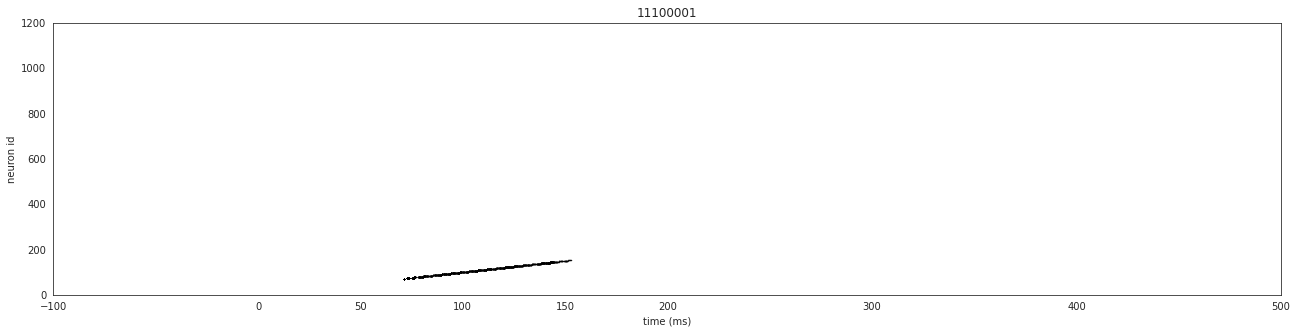

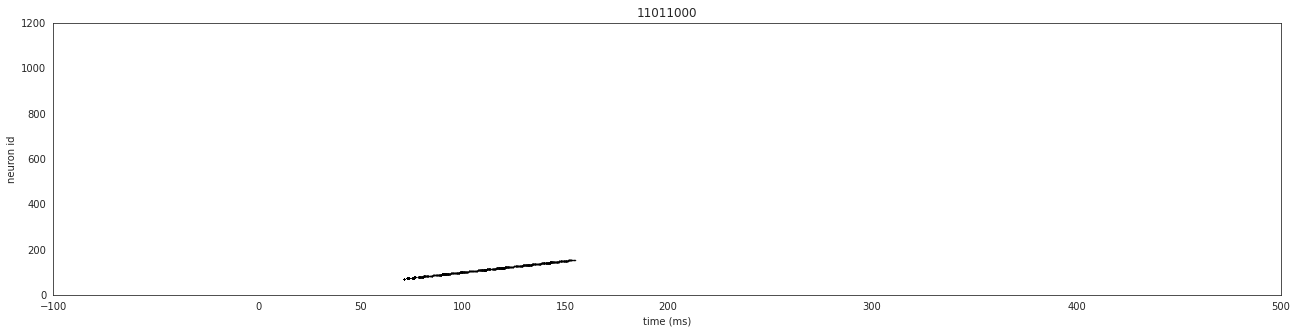

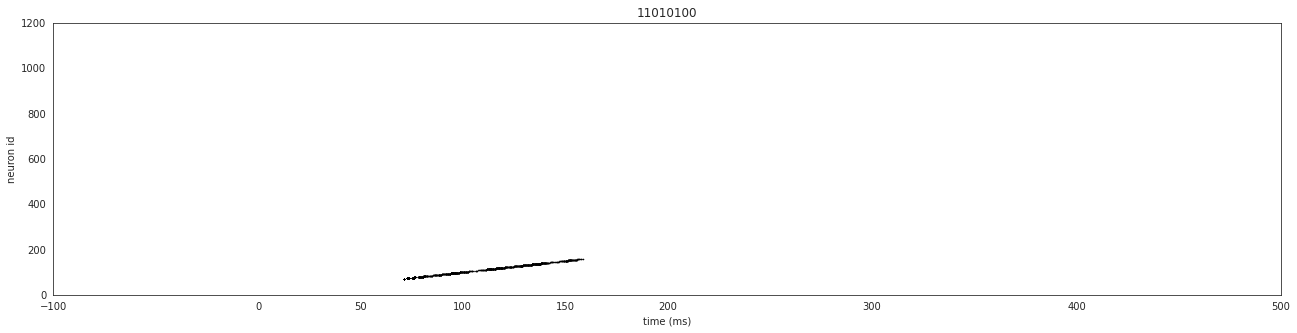

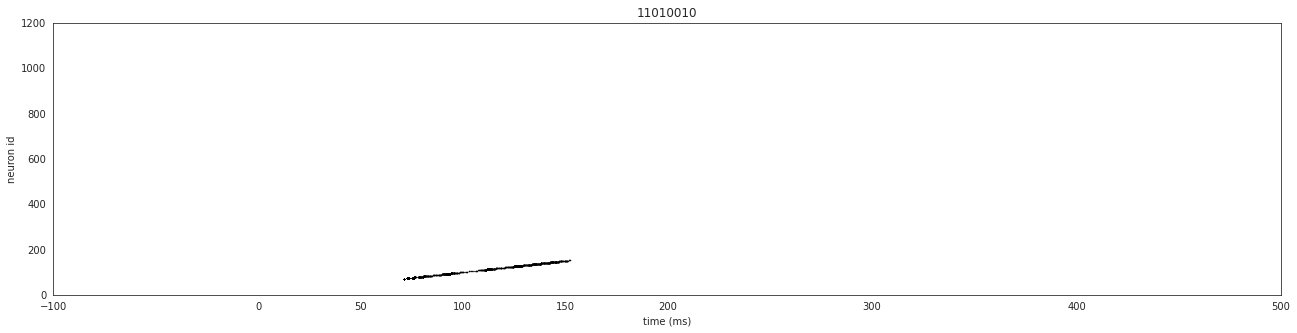

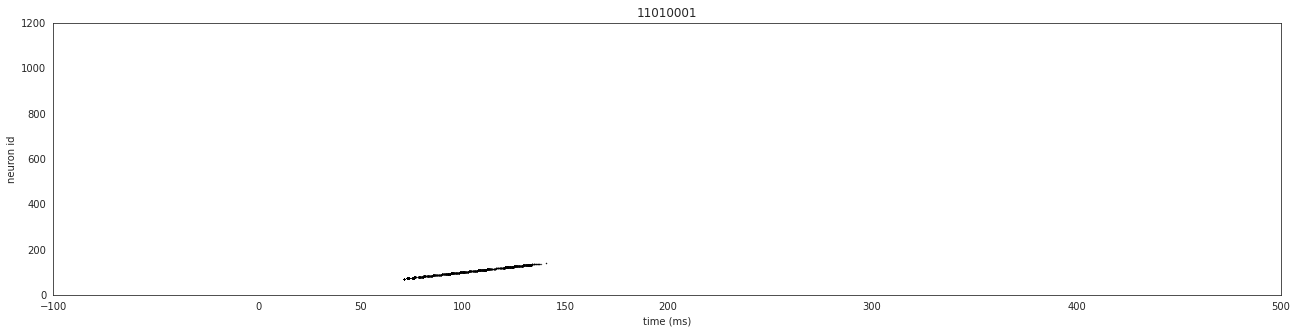

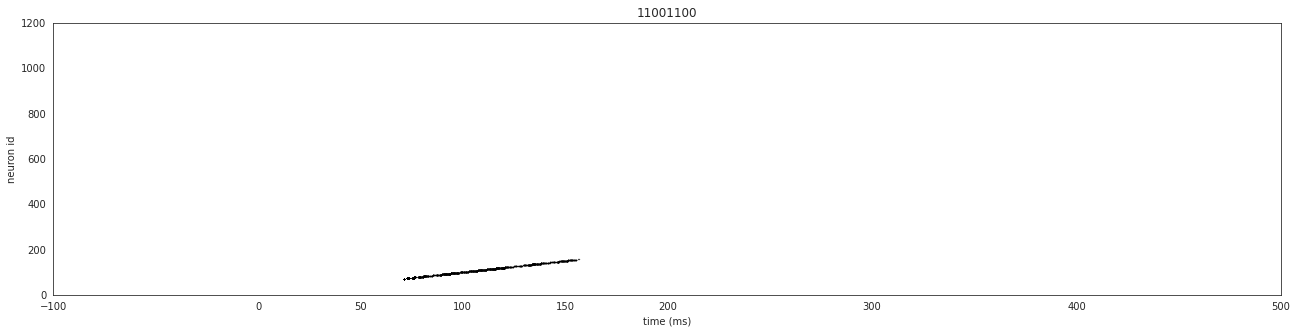

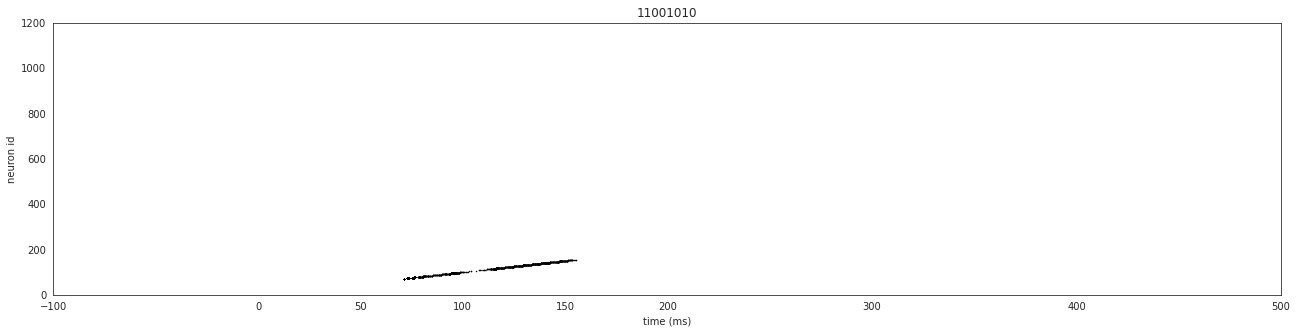

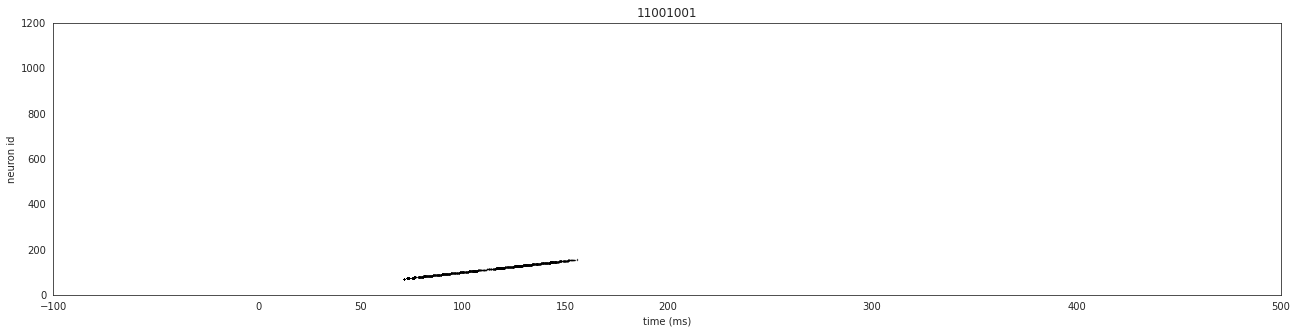

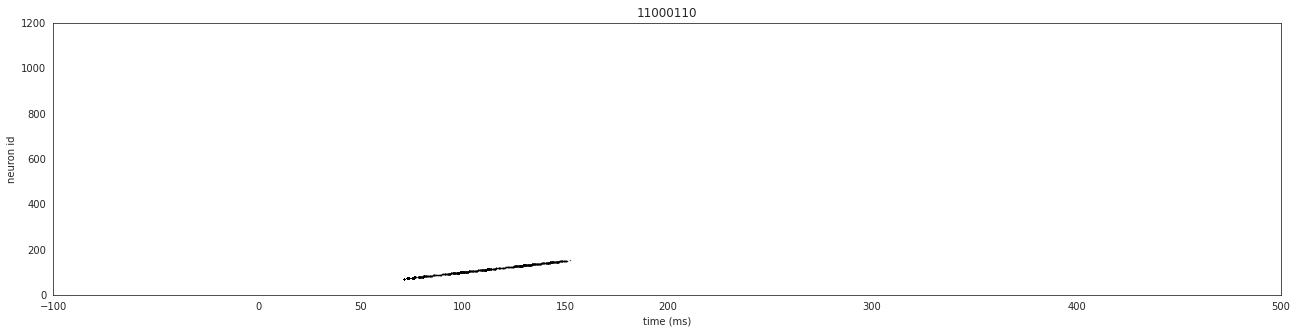

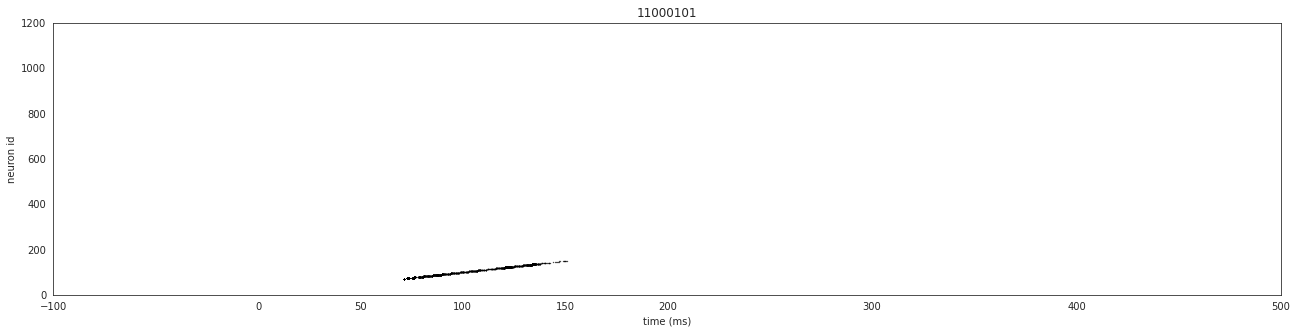

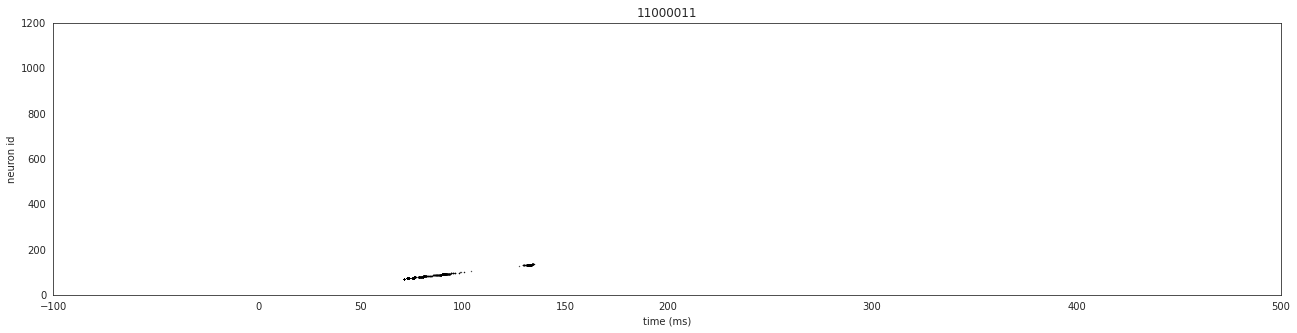

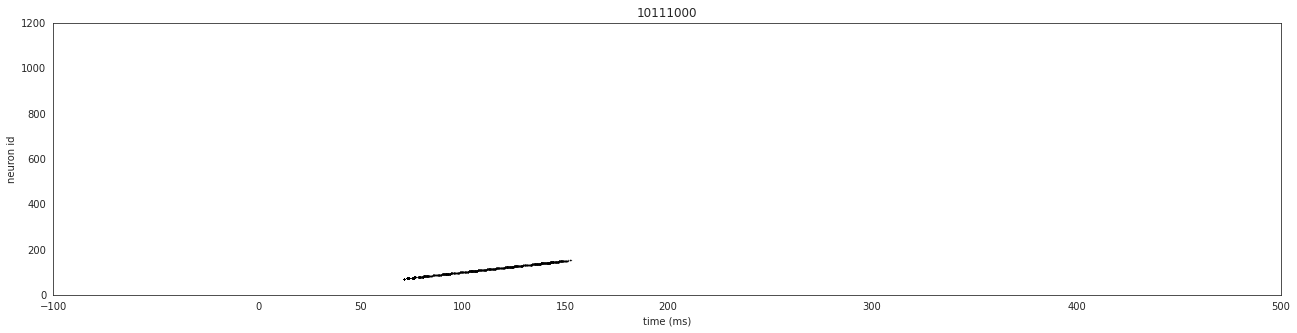

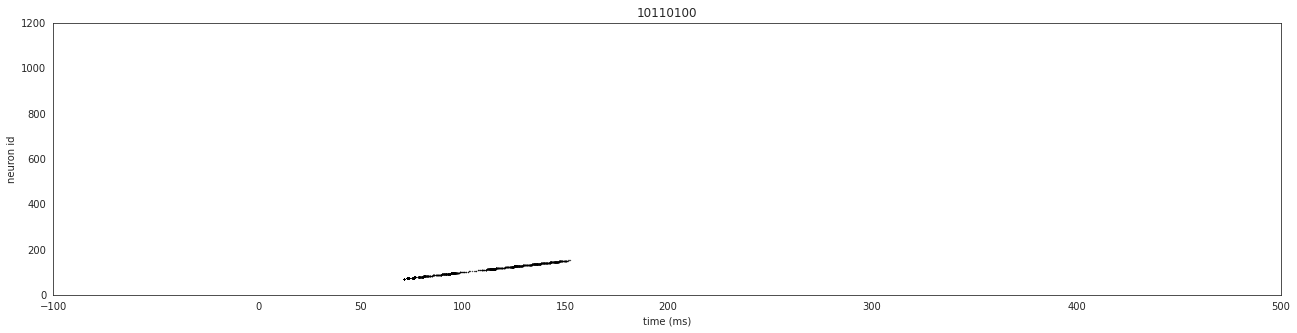

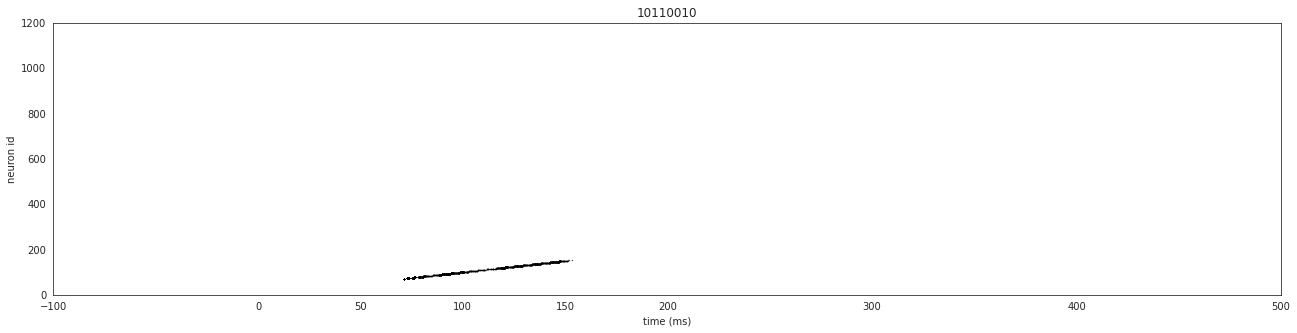

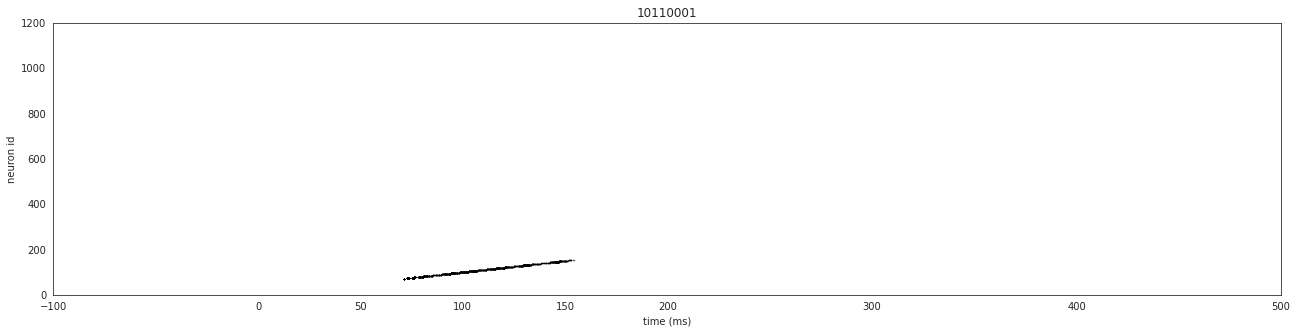

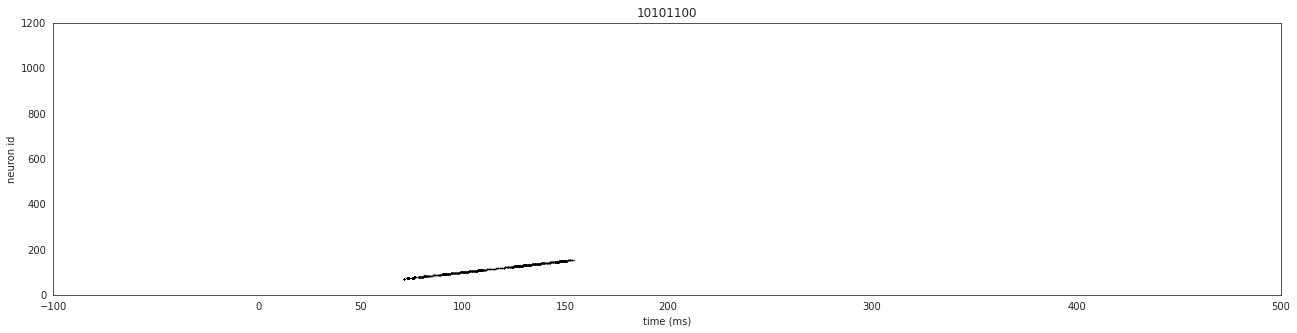

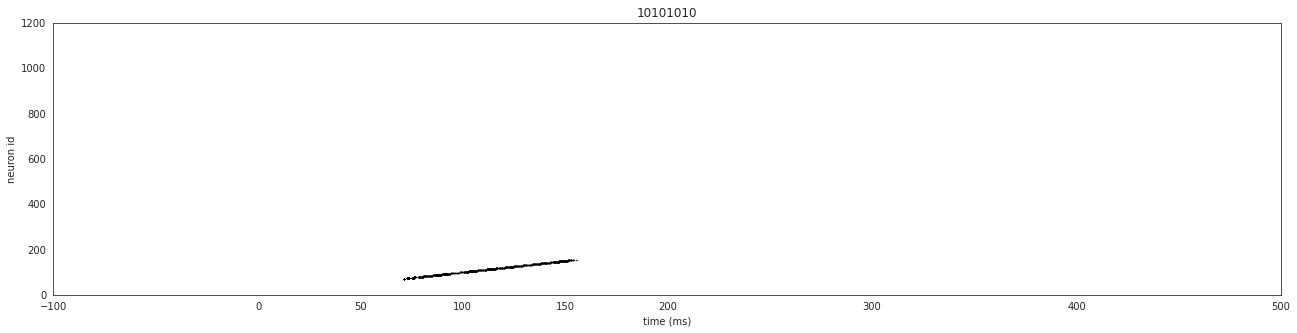

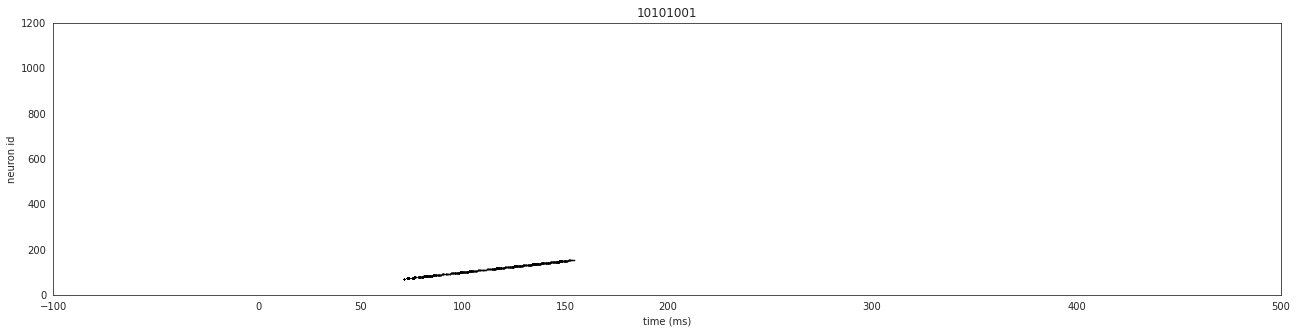

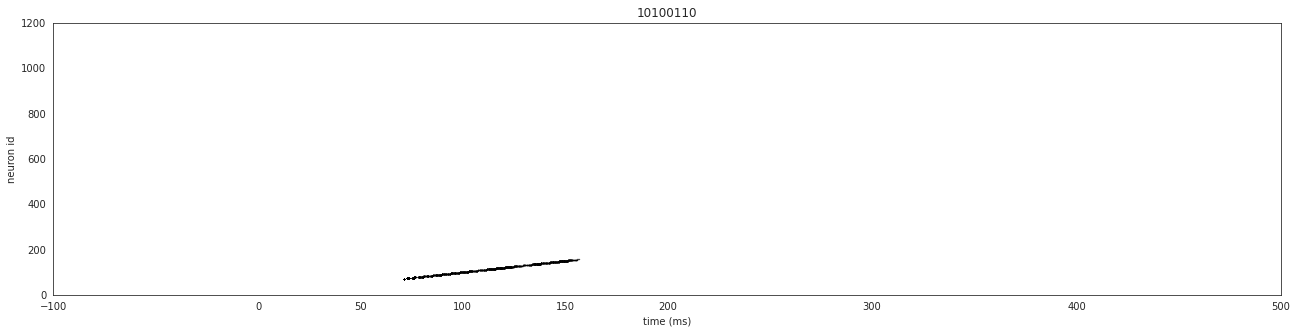

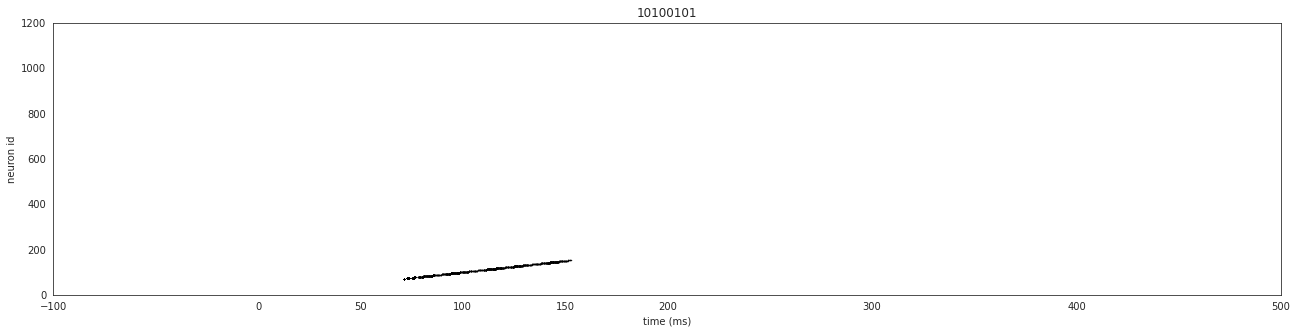

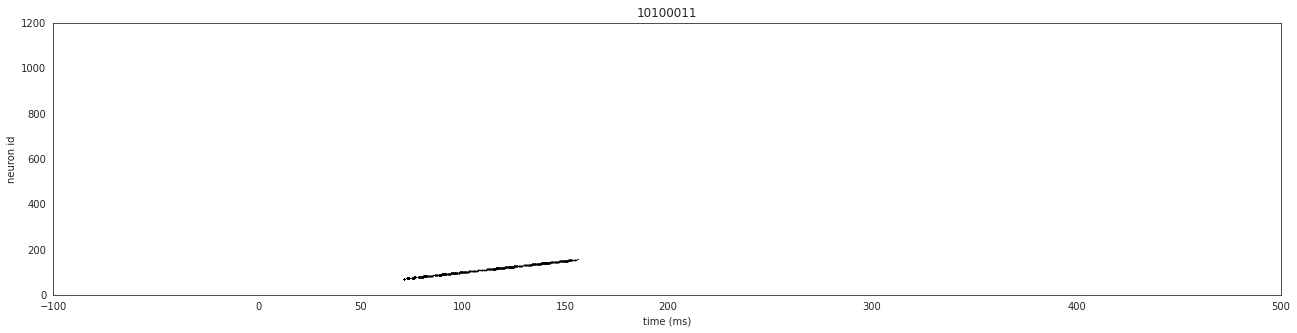

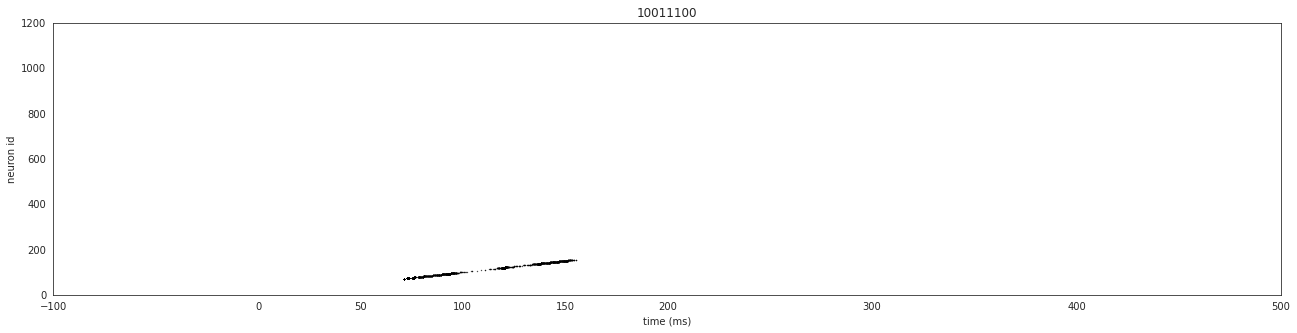

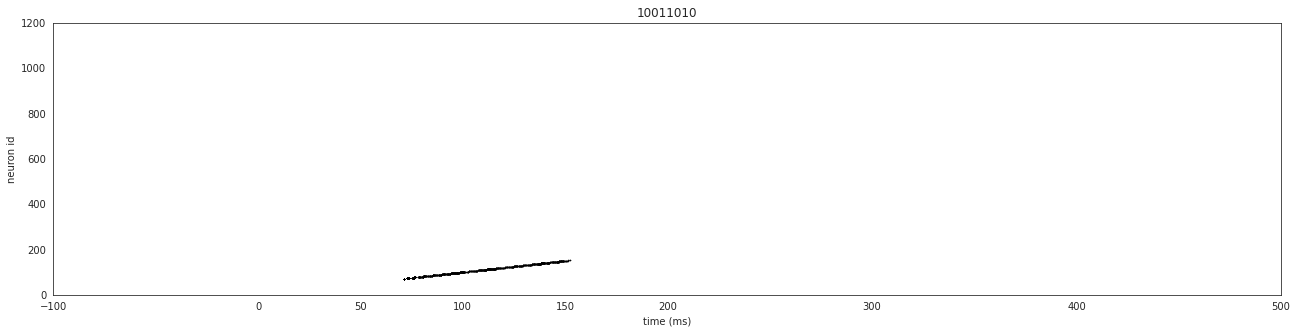

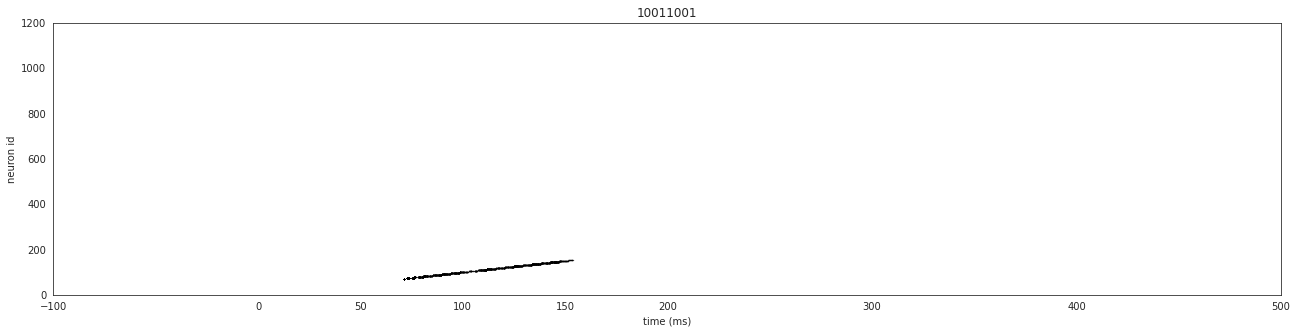

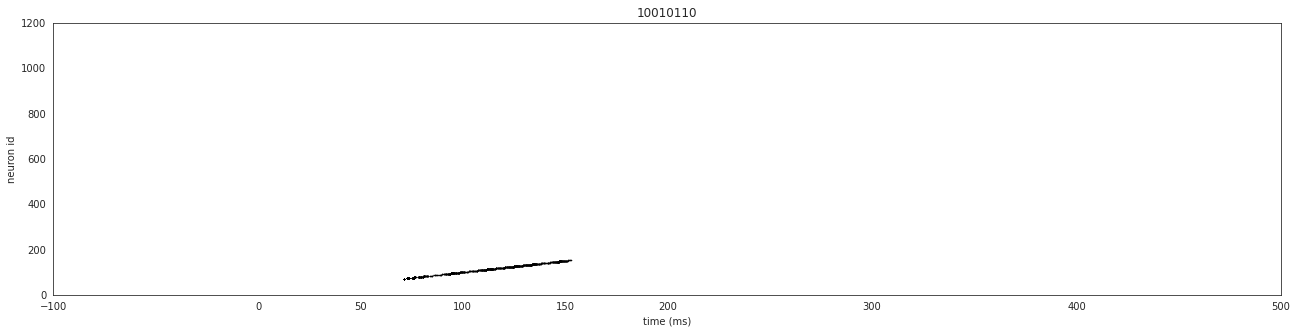

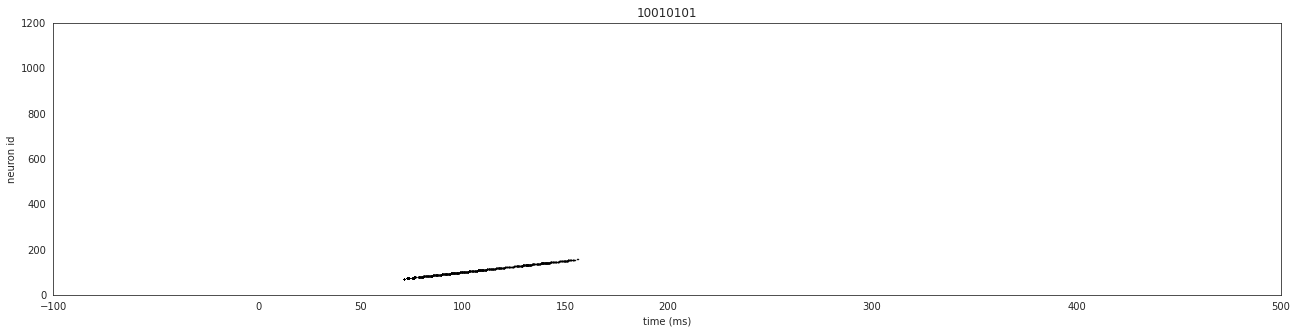

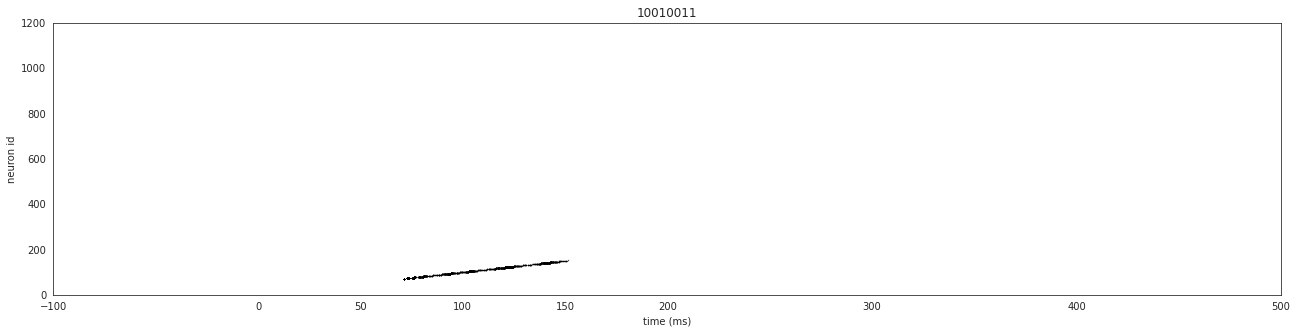

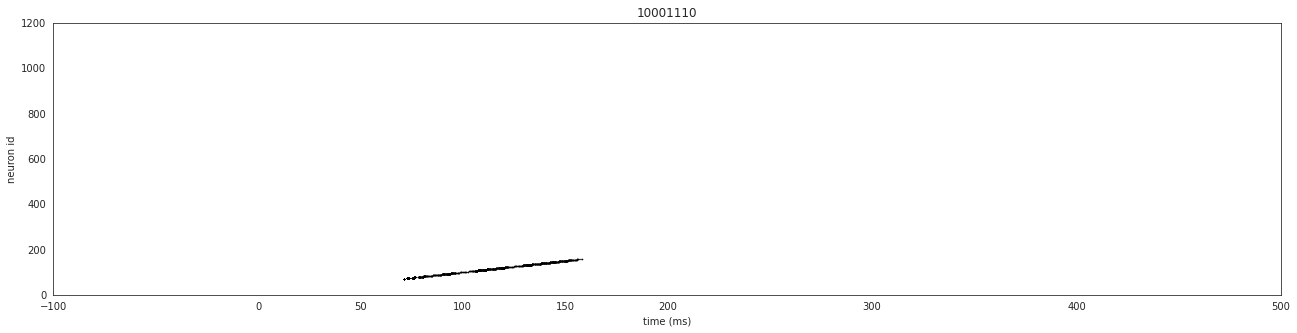

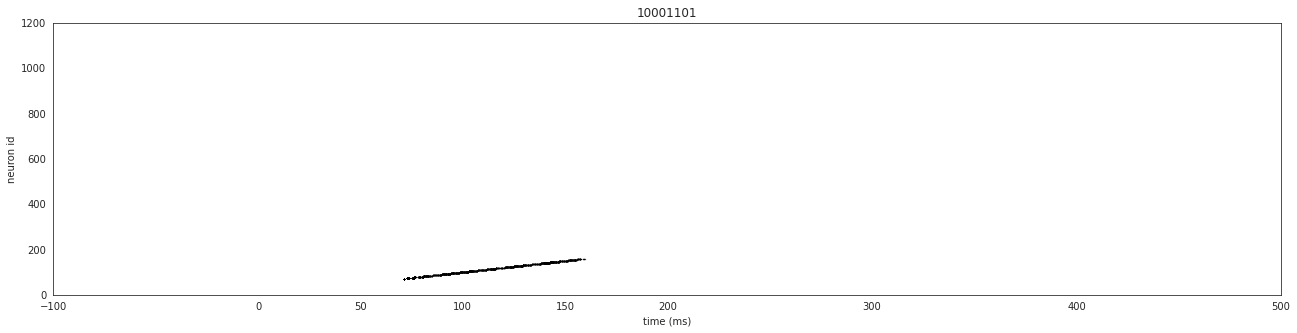

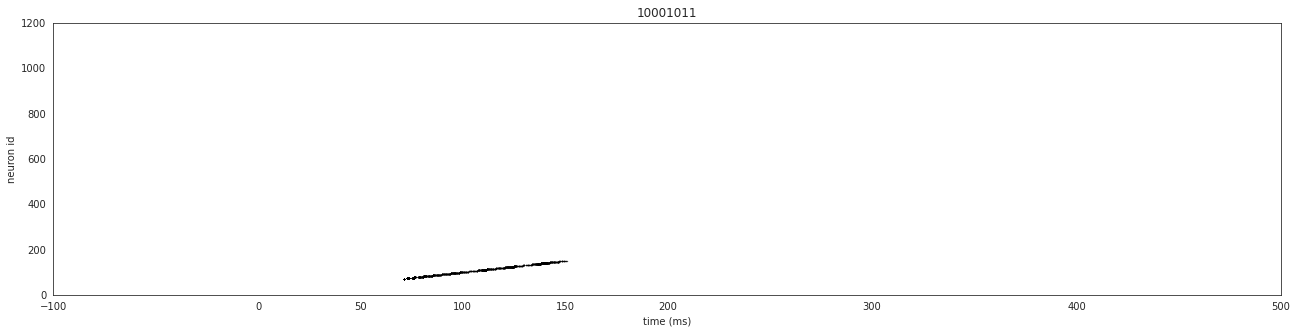

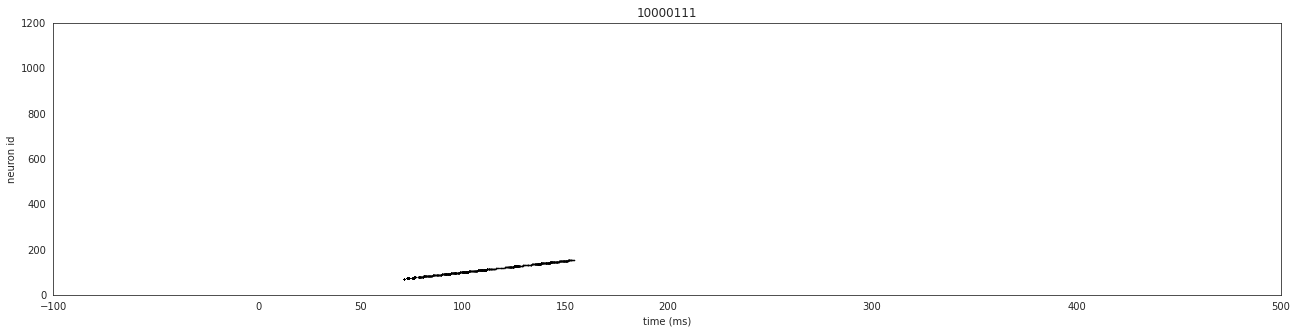

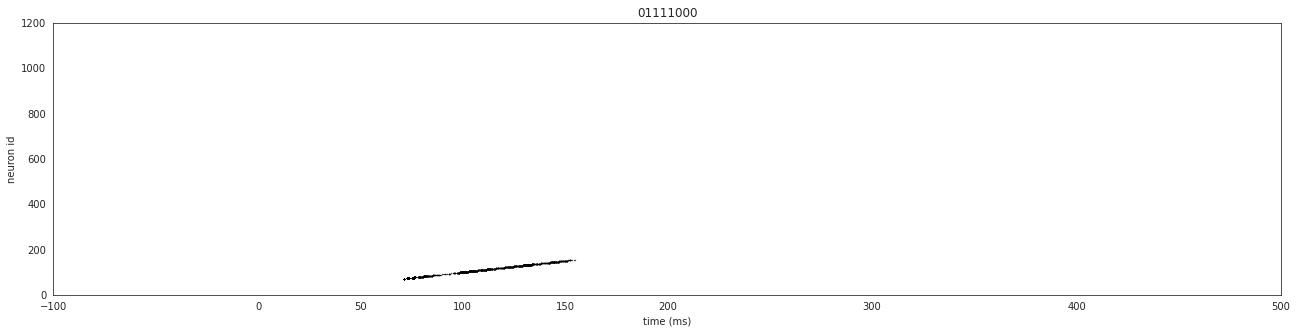

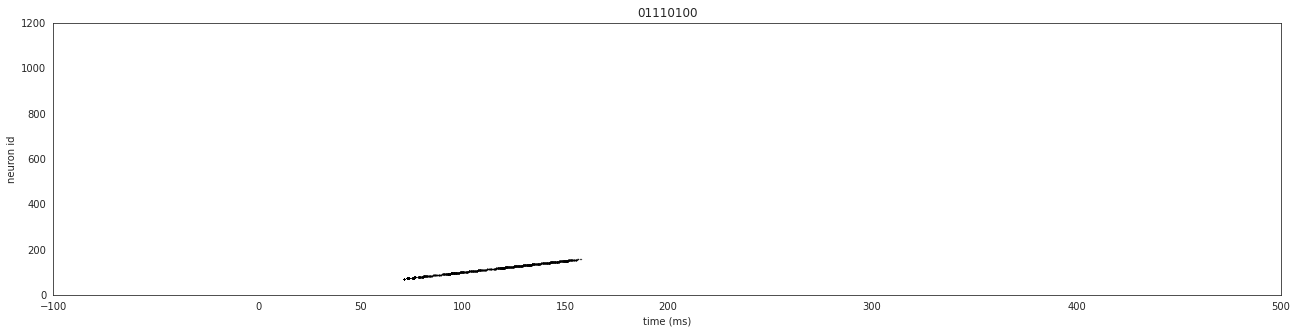

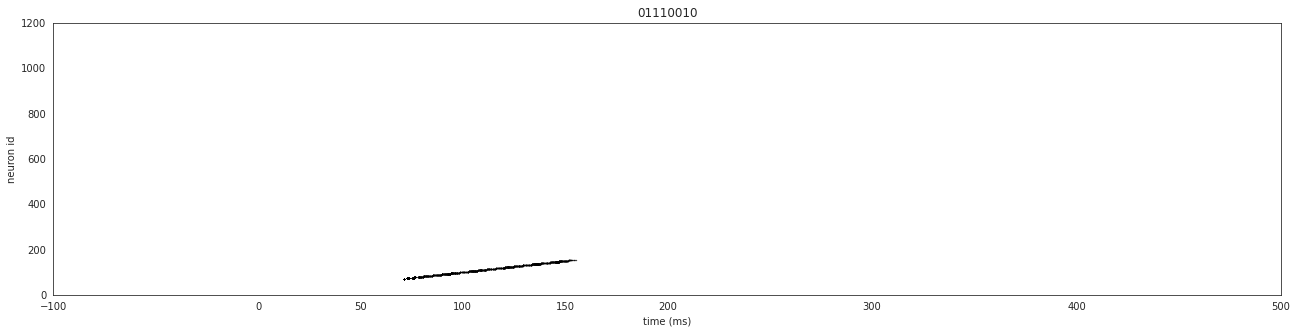

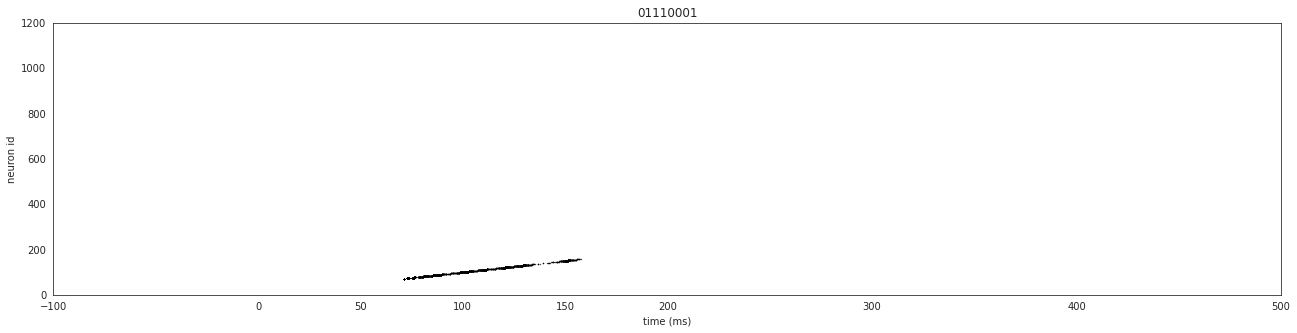

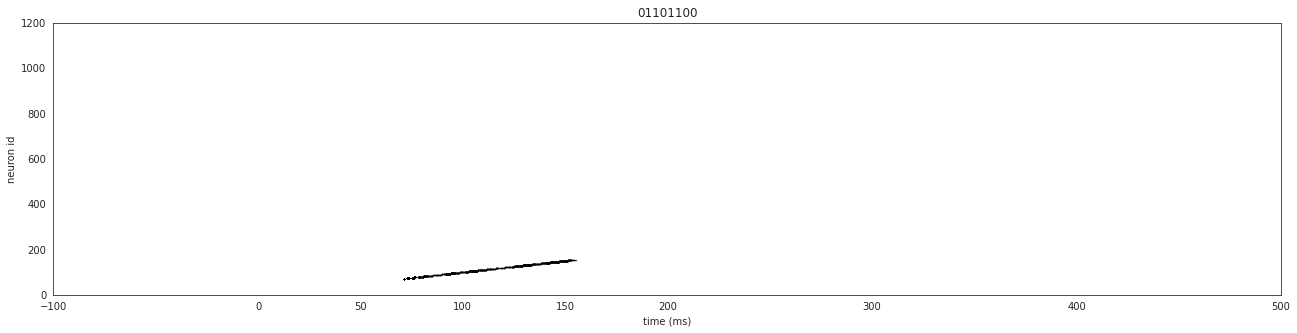

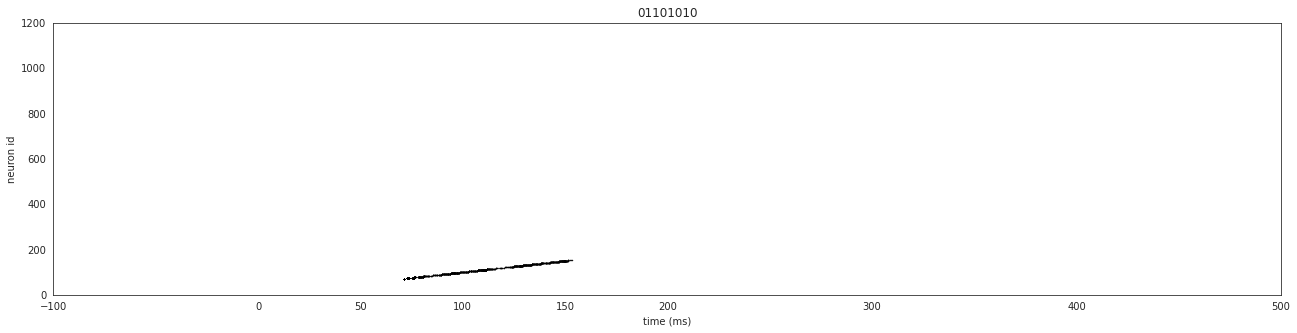

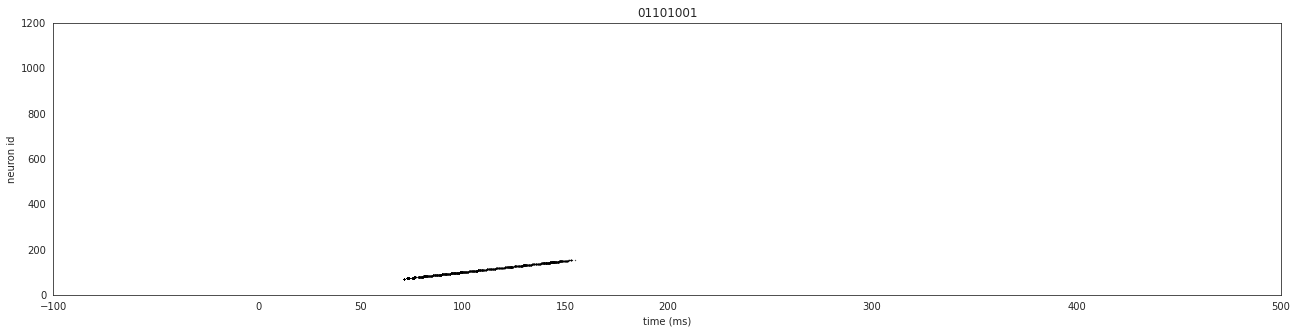

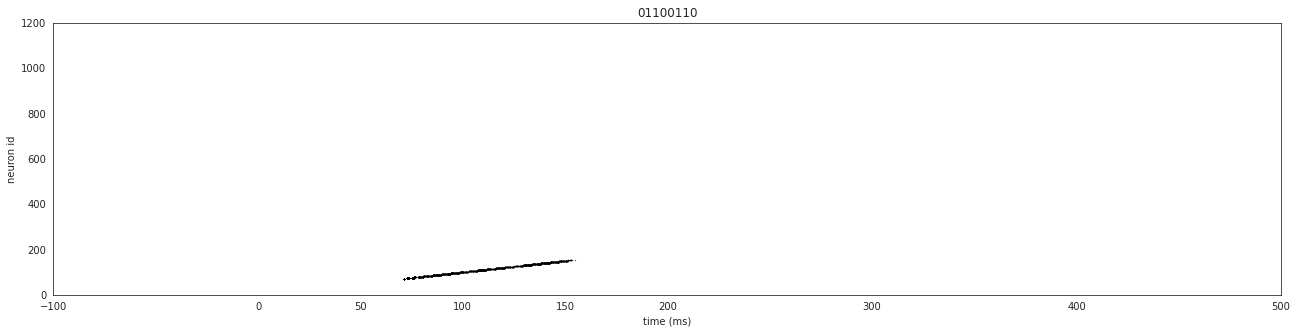

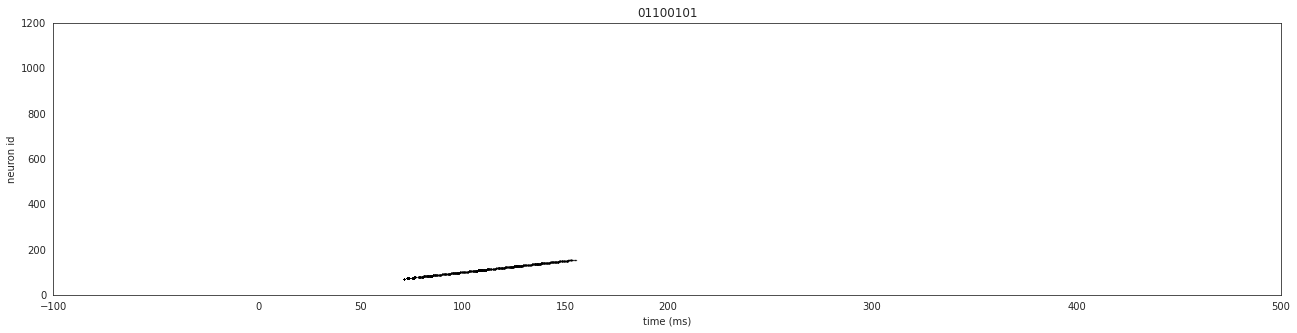

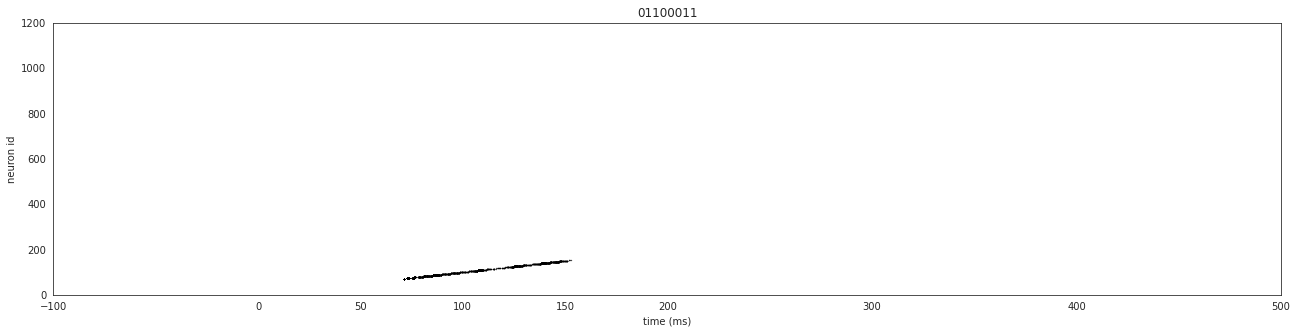

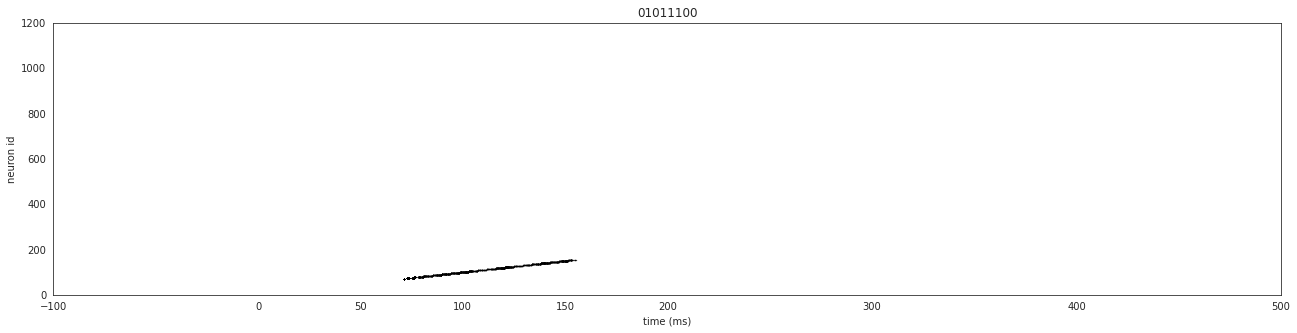

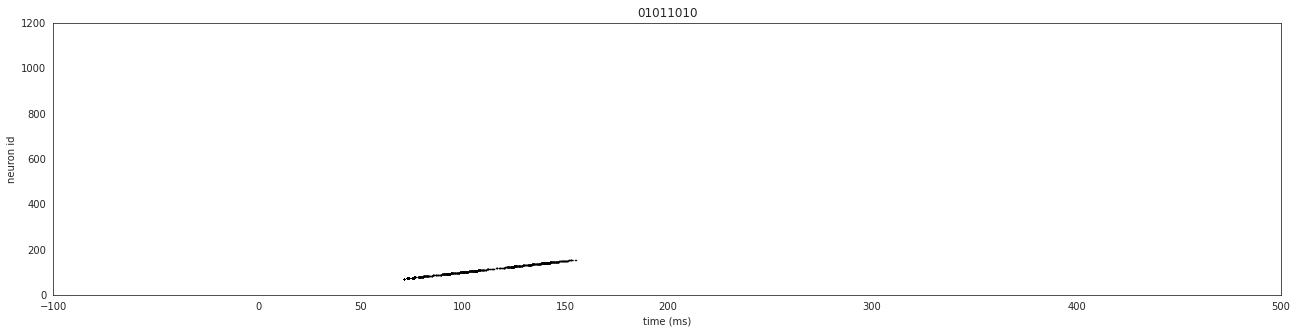

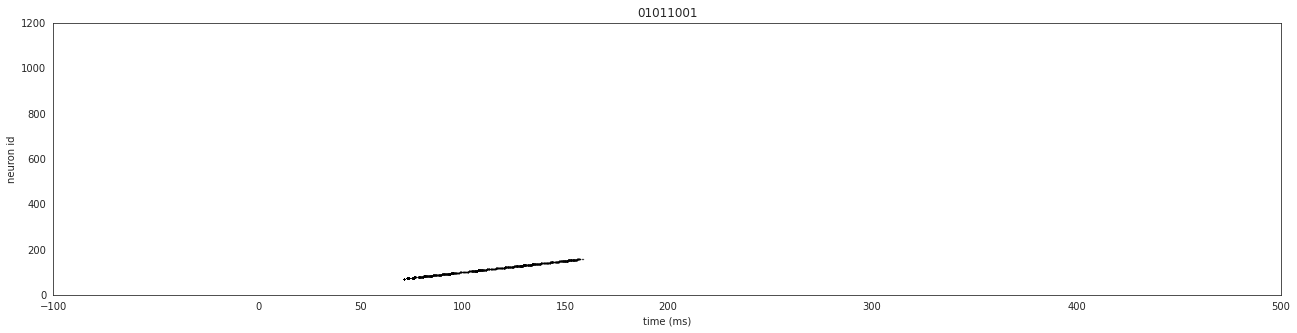

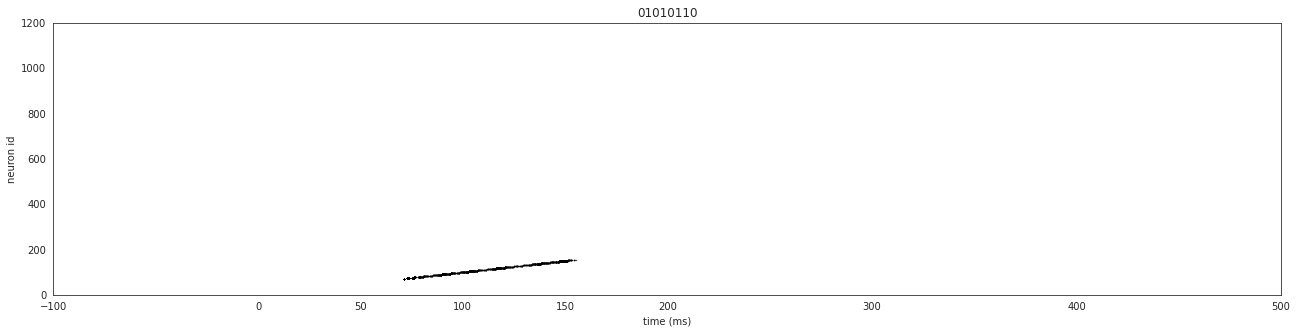

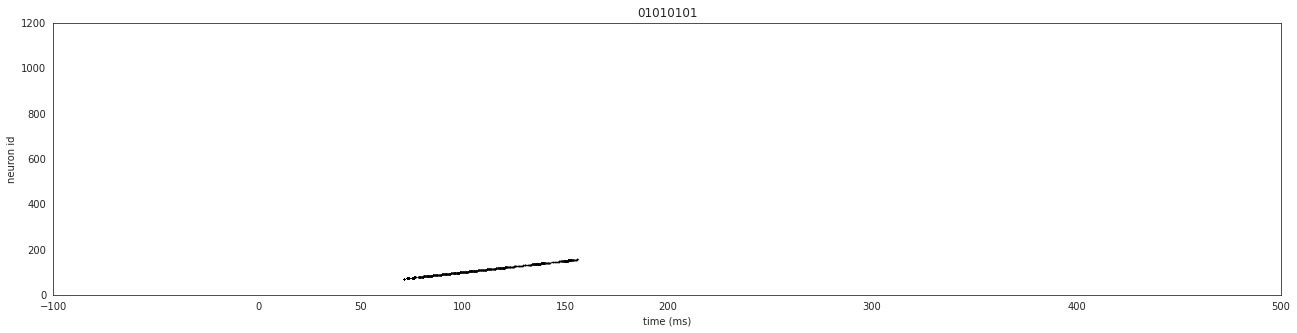

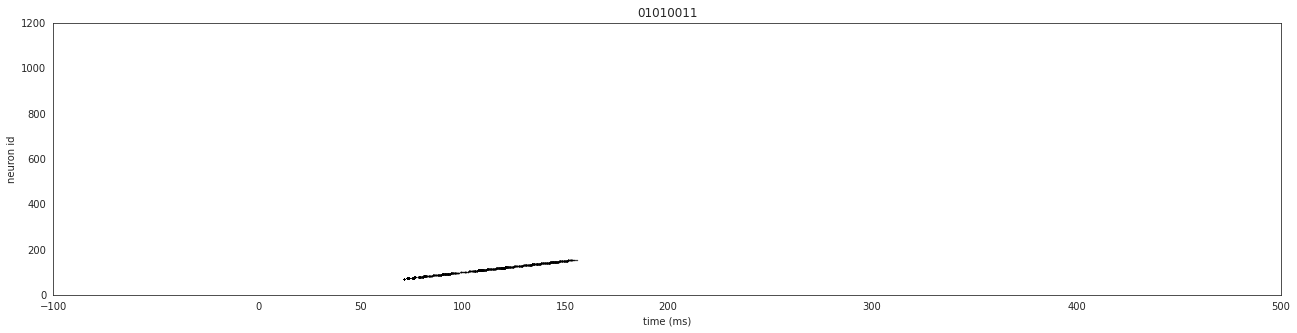

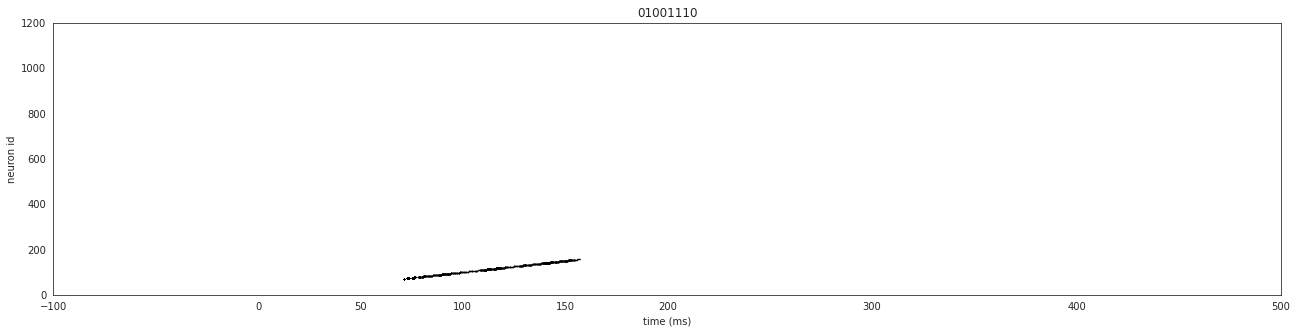

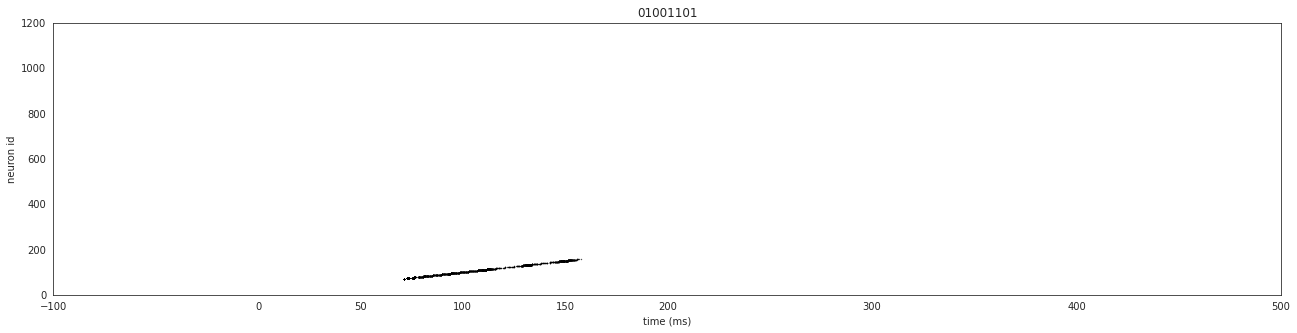

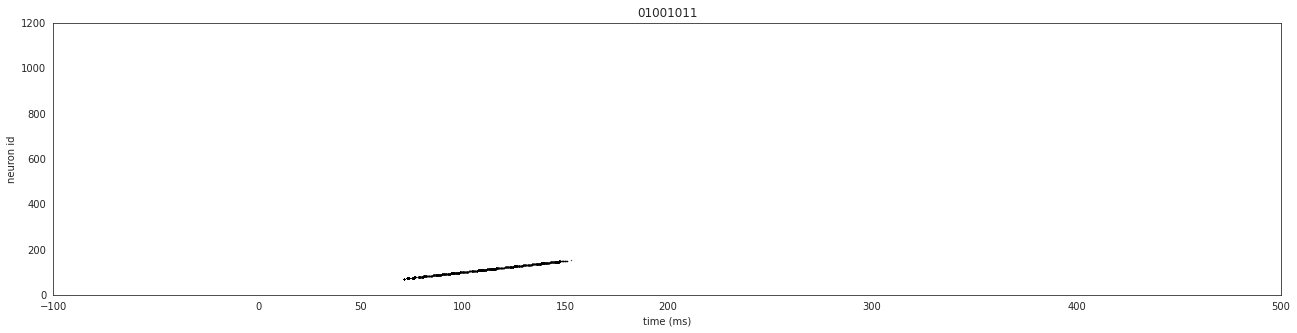

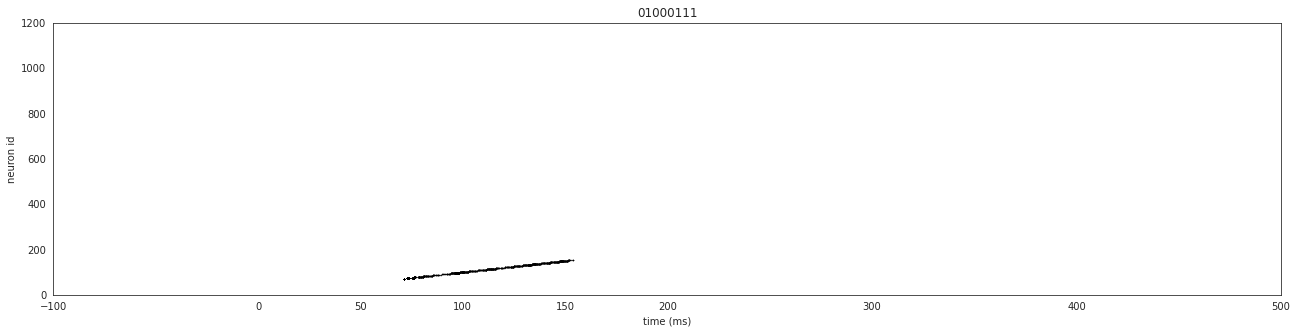

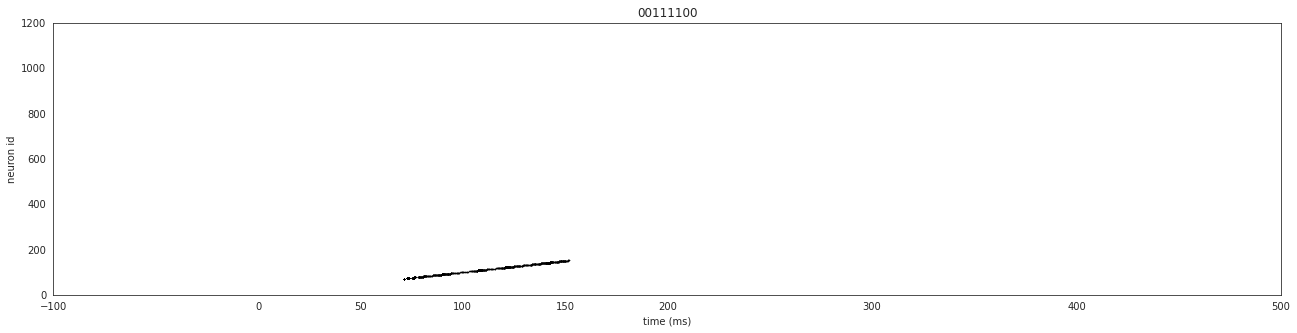

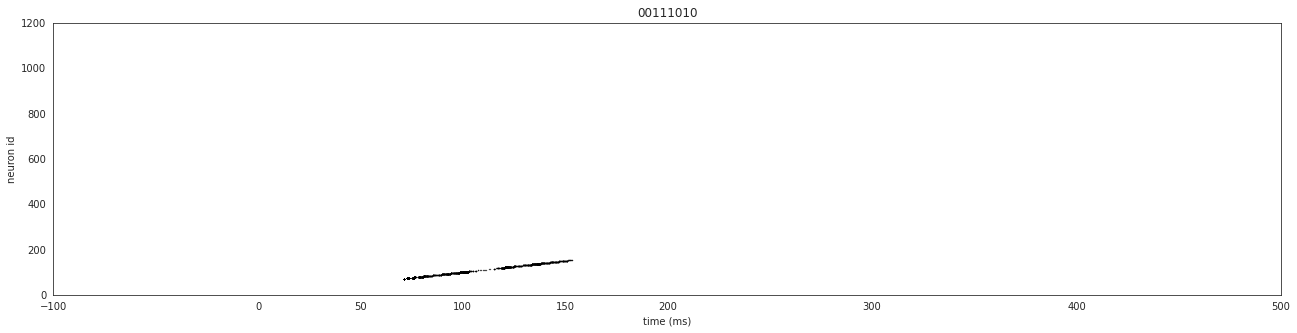

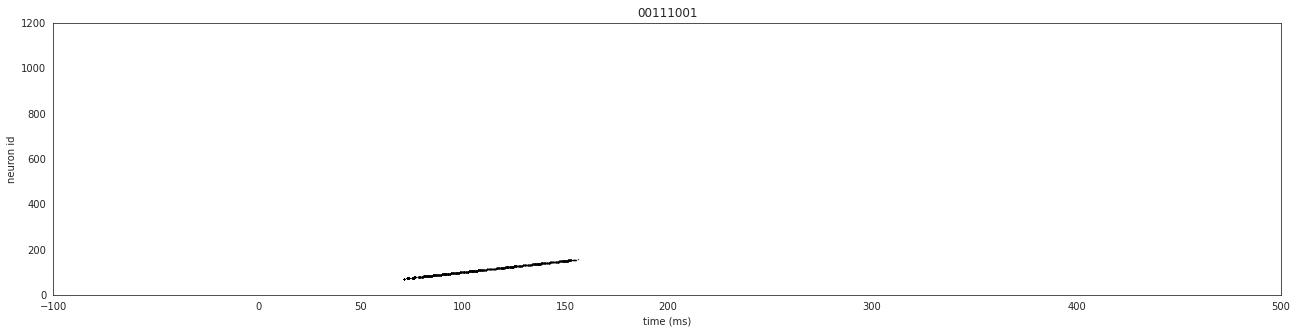

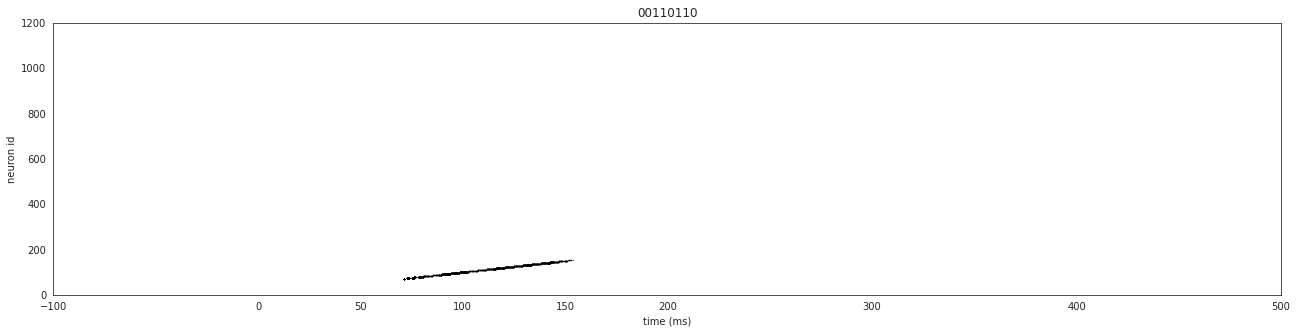

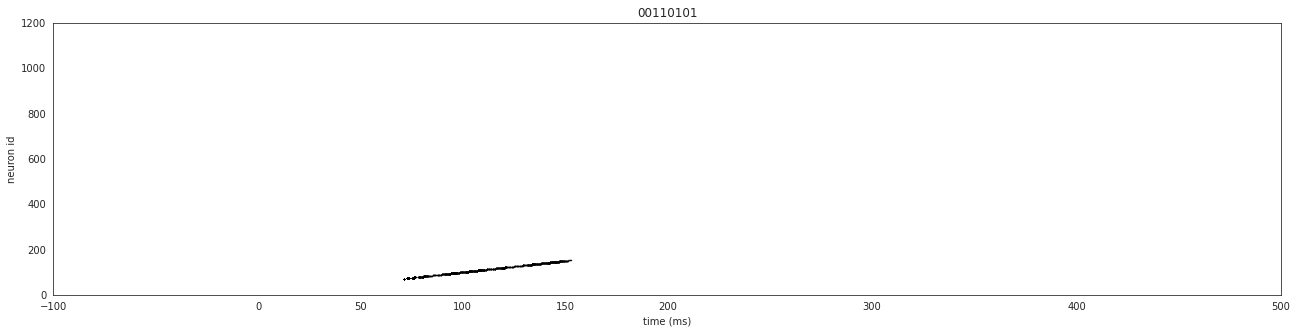

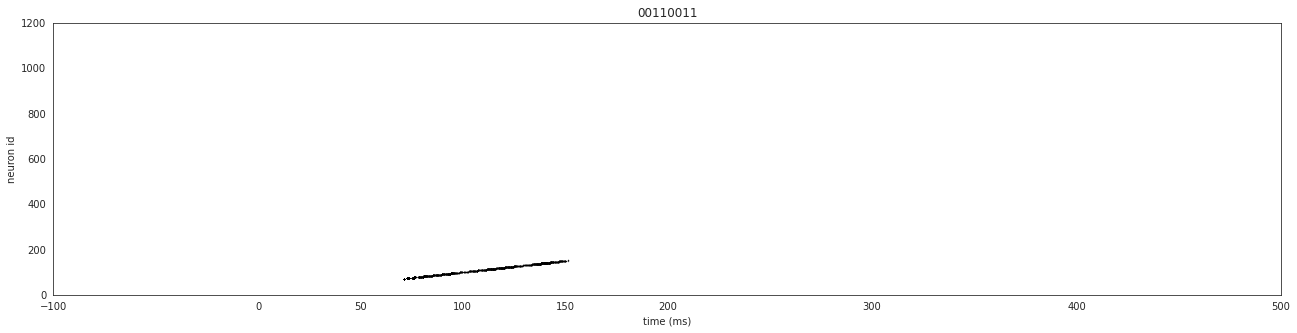

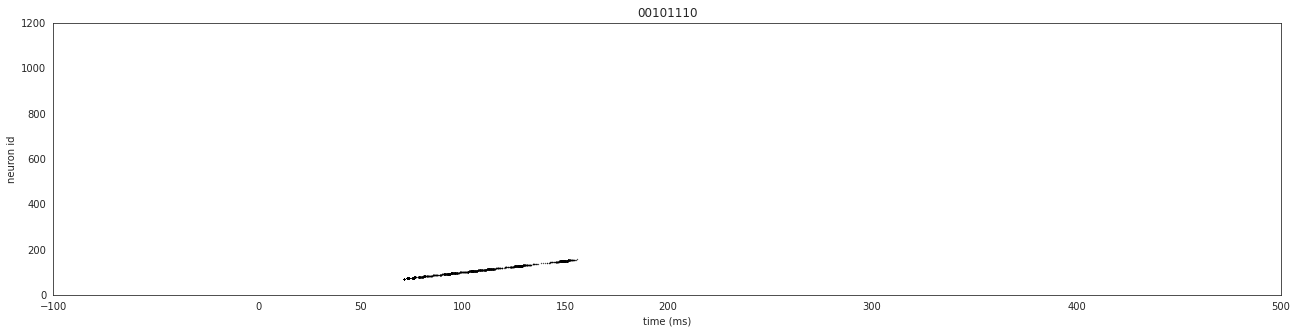

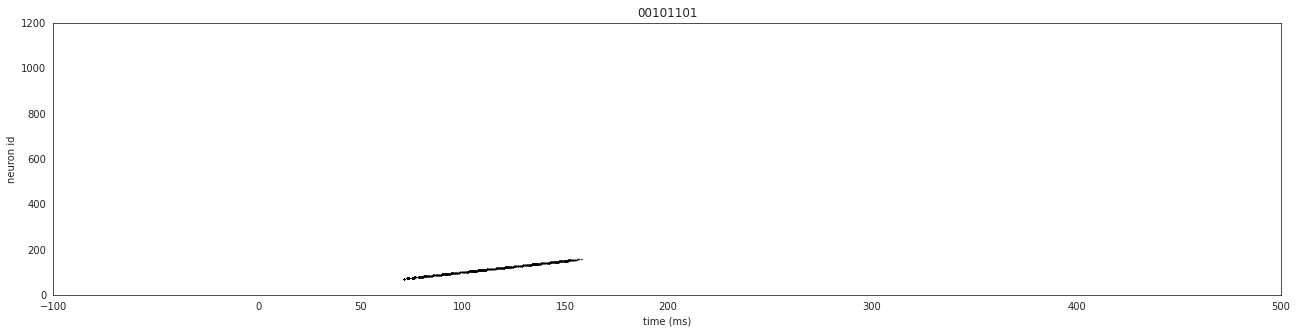

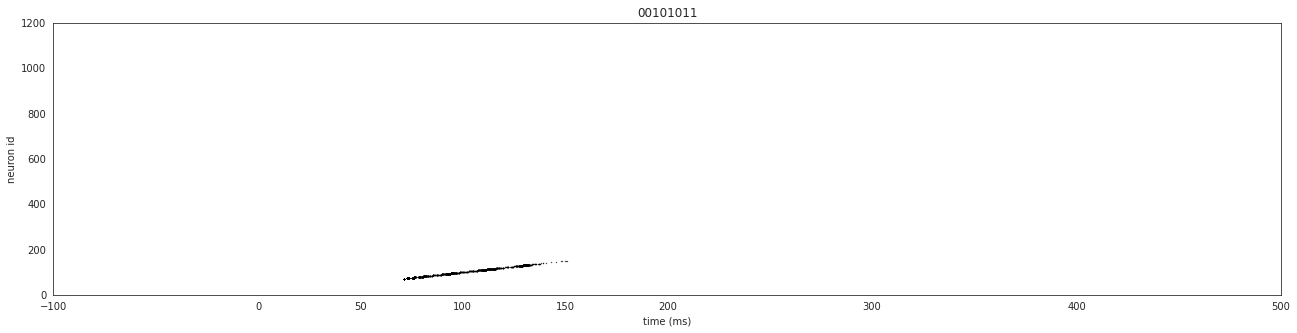

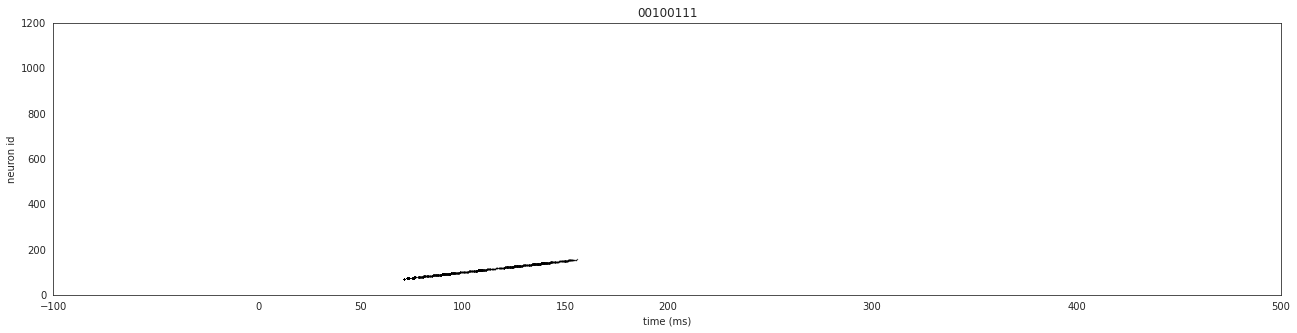

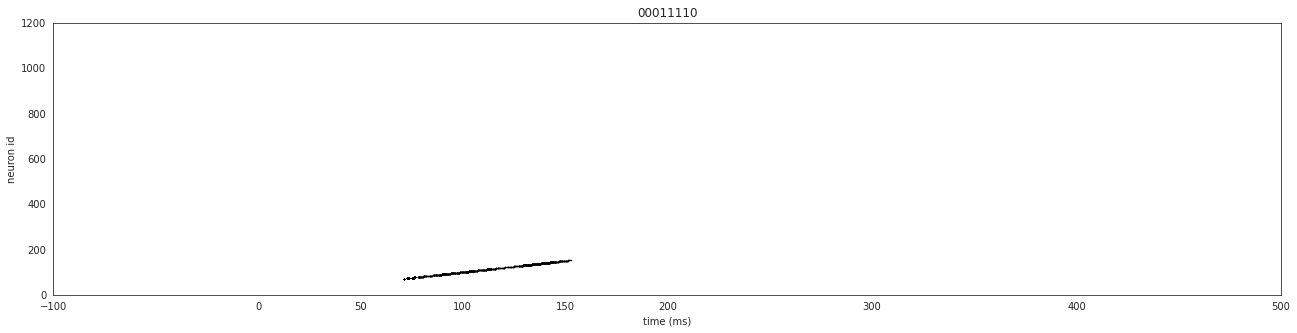

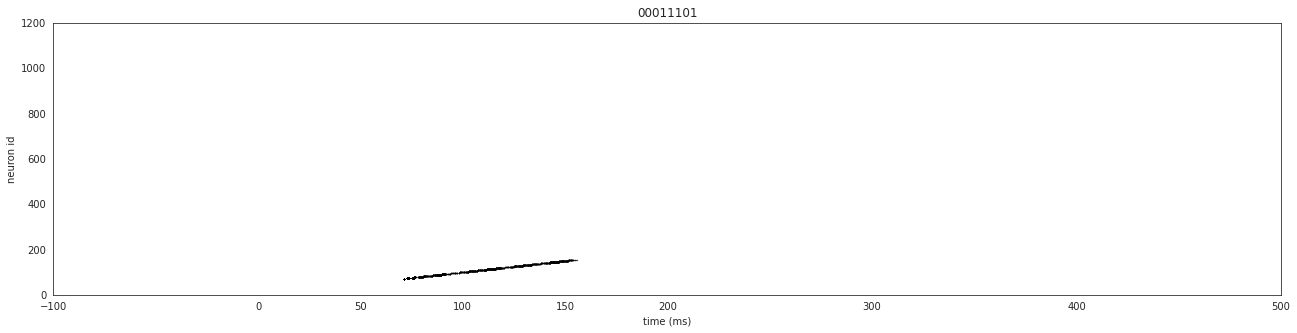

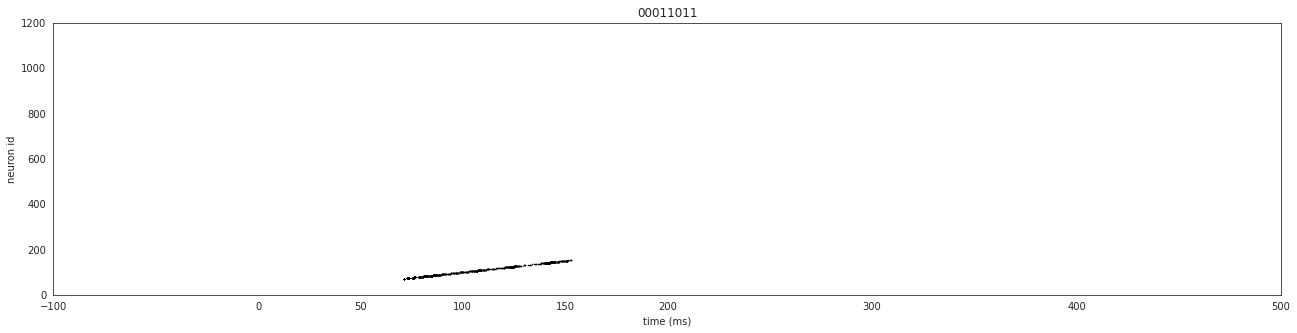

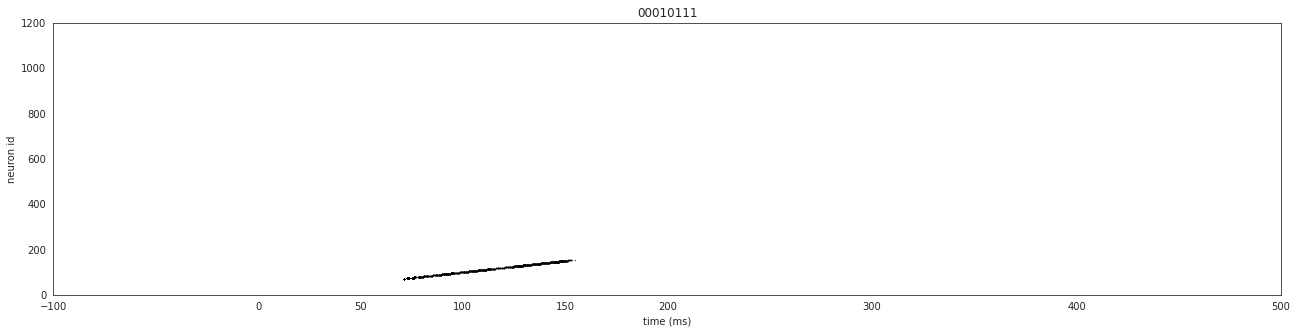

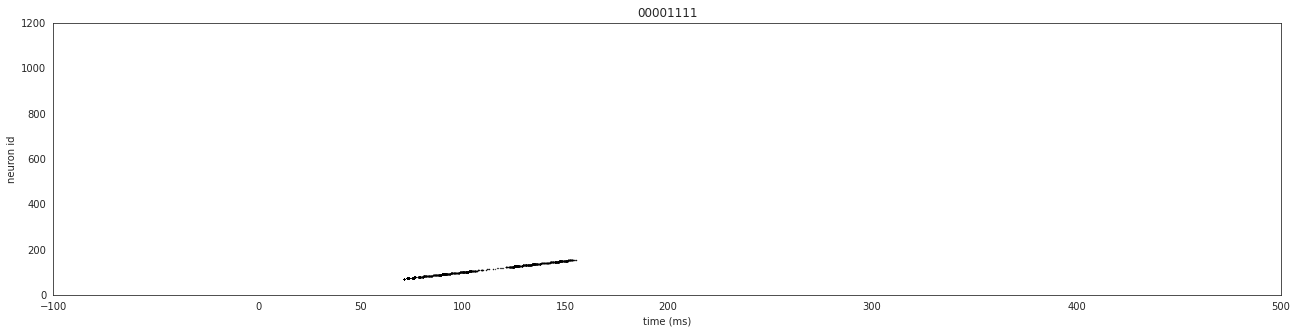

In [256]:
for i, pattern in enumerate(patterns):
    # make raster plots
    f = plt.figure(figsize=(22,5))
    plt.title(H.list2str(pattern))
    plt.scatter(spike_times_arr[i],spike_neurons_arr[i], marker='o', s=.1, color='k');
    plt.xlabel('time (ms)')
    plt.ylabel('neuron id')
    plt.axis([-100,500,0, N_total])
    plt.xticks(list(plt.xticks()[0]) + [50,stim_end]) # add some extra ticks for clarity
    #plt.savefig(path+str(H.list2str(pattern))) uncommment to save figures

### 5.3 Zoomed in raster plots

/home/nest/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


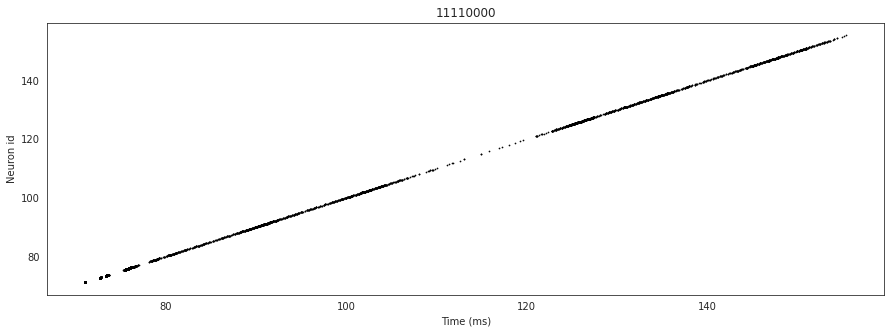

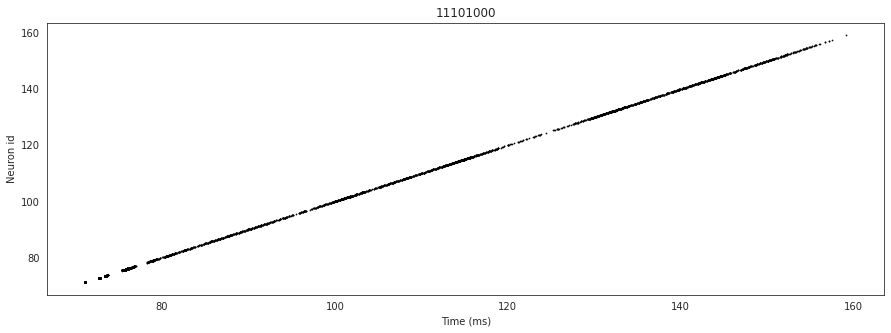

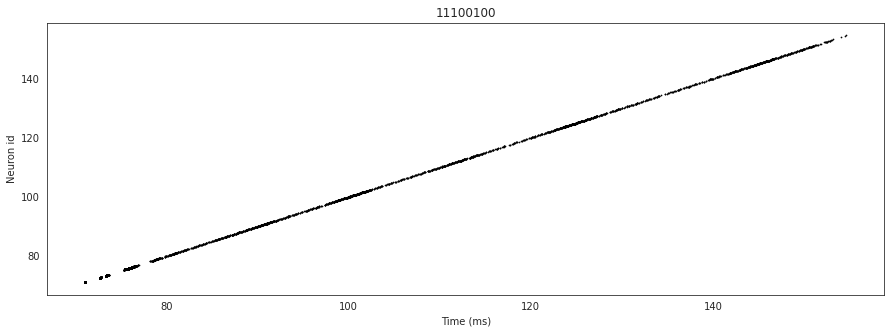

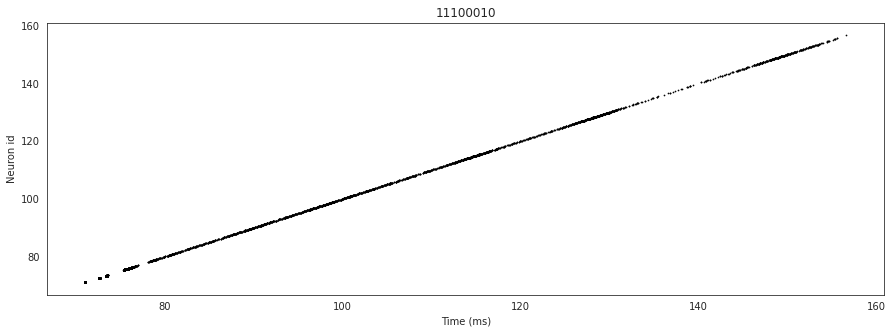

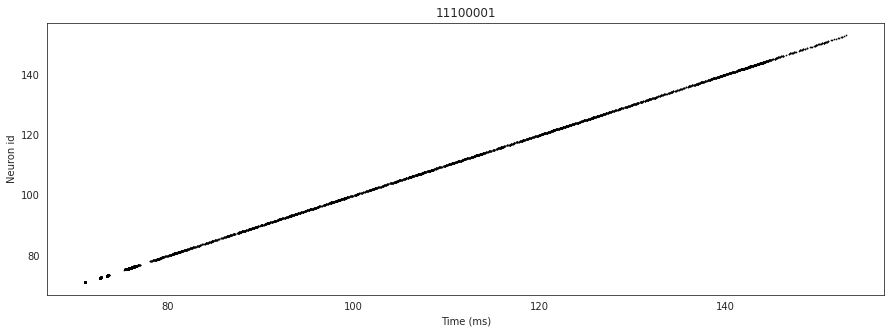

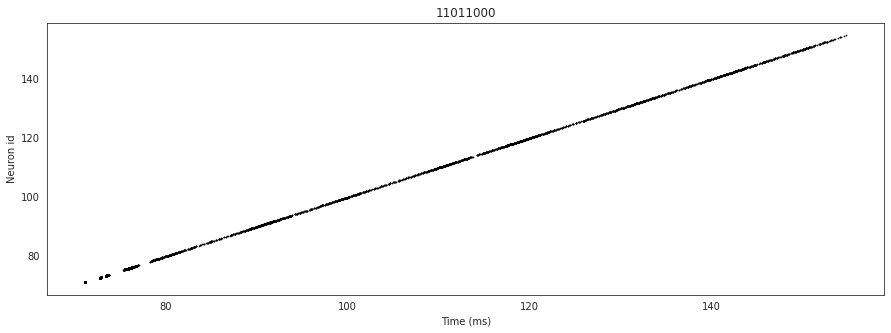

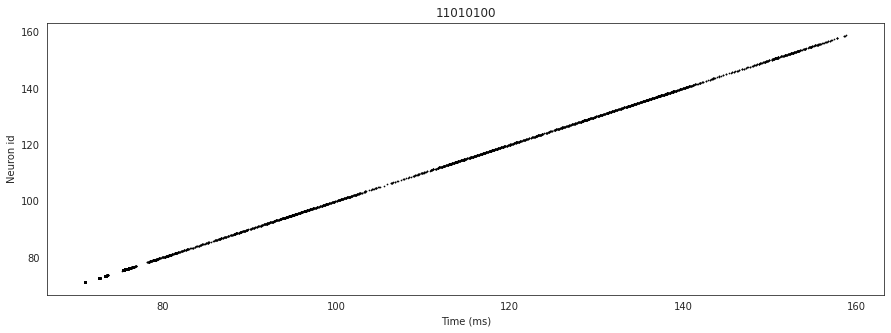

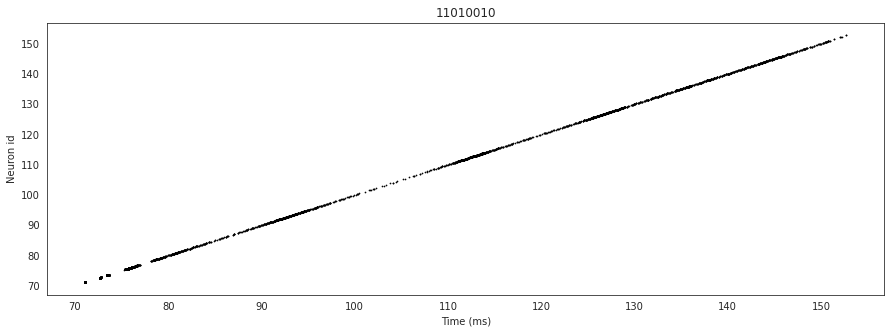

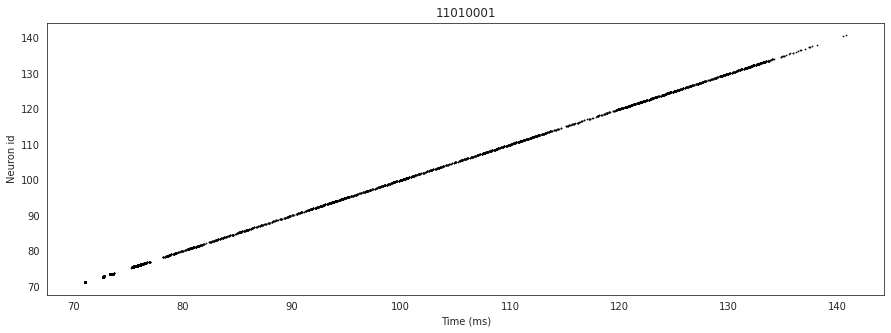

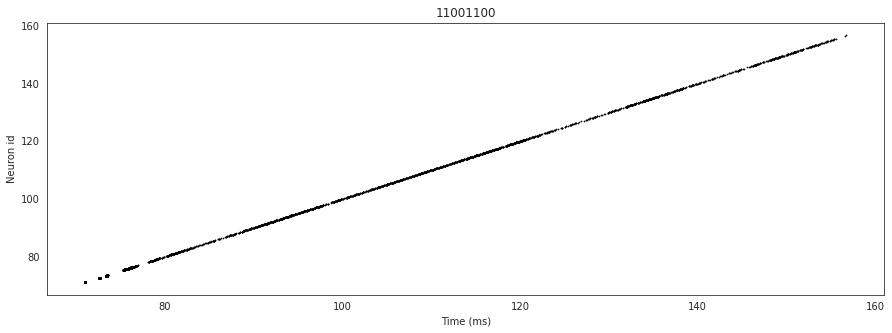

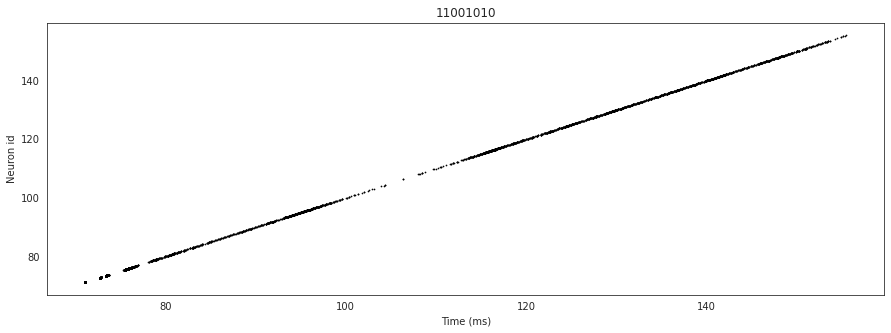

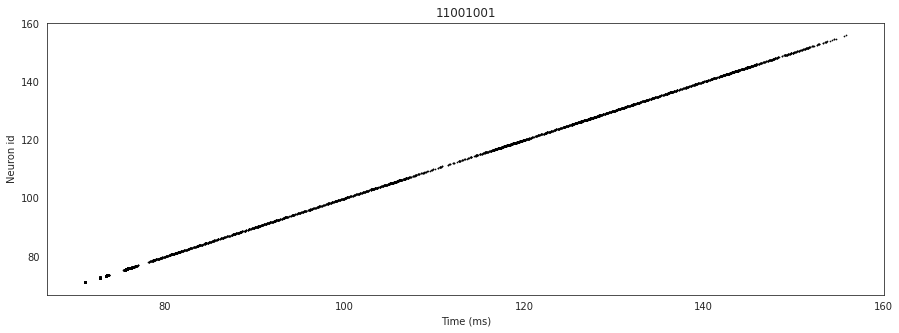

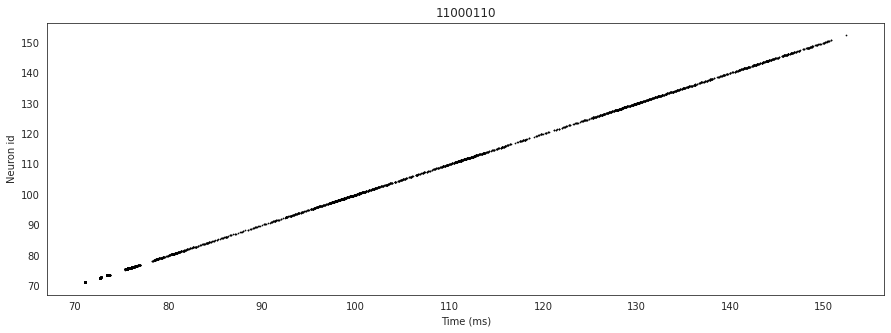

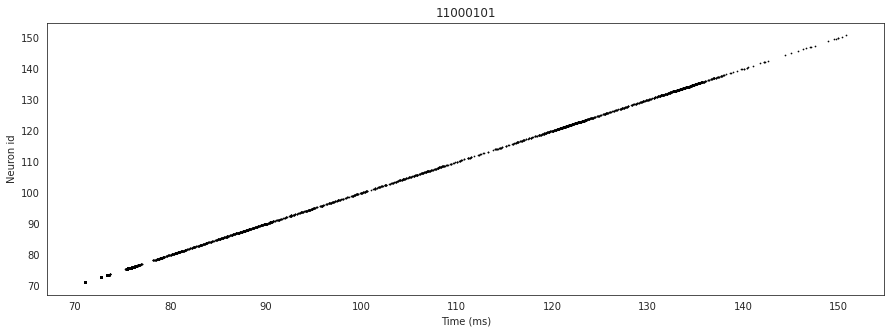

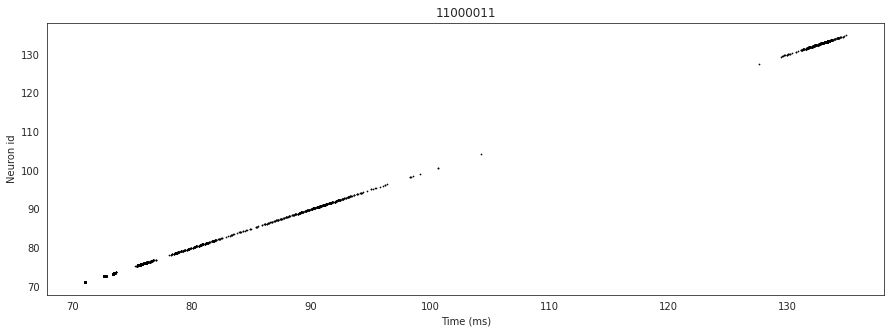

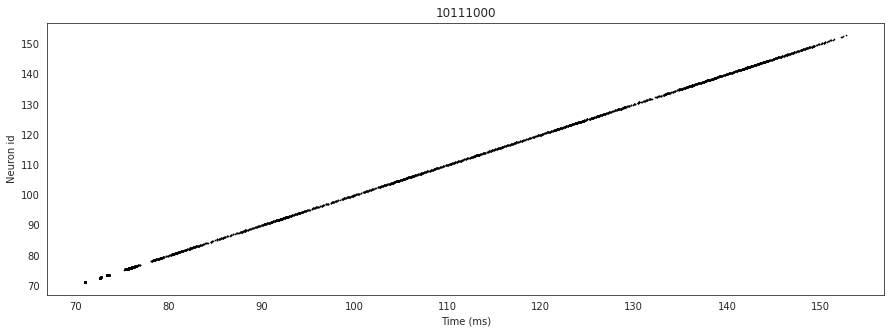

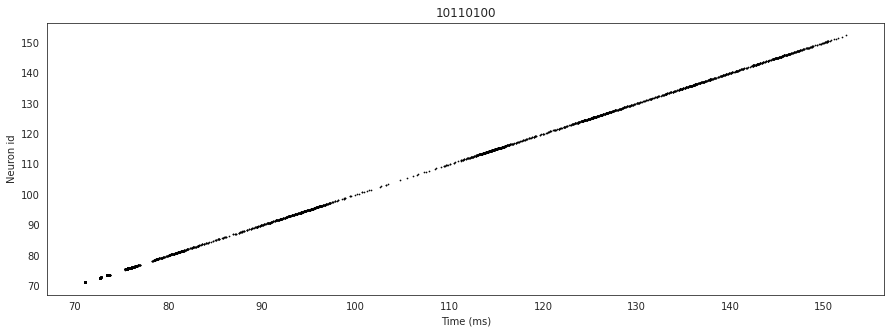

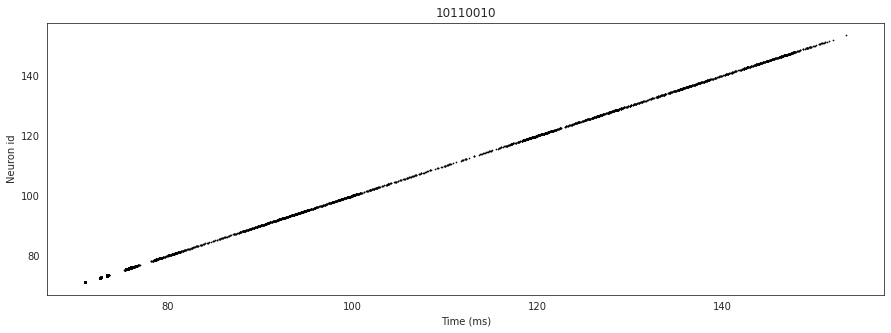

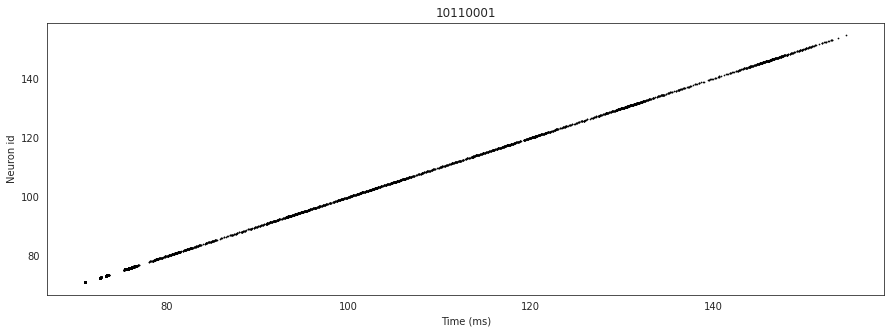

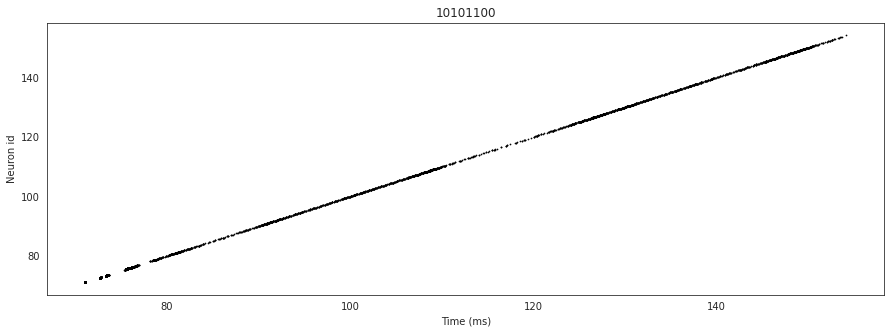

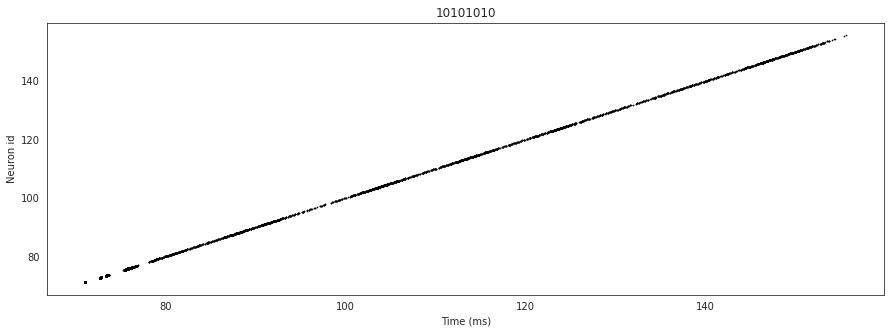

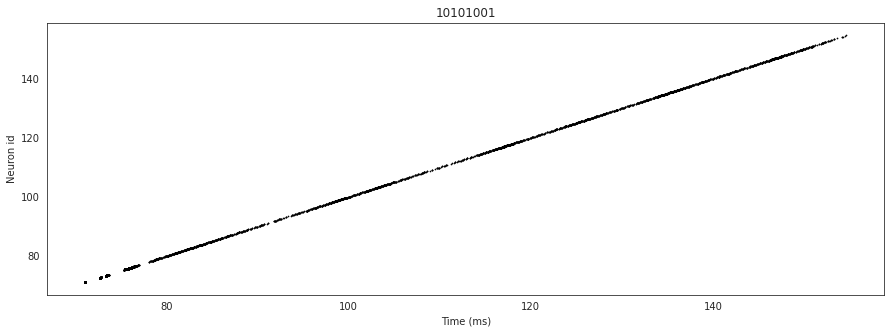

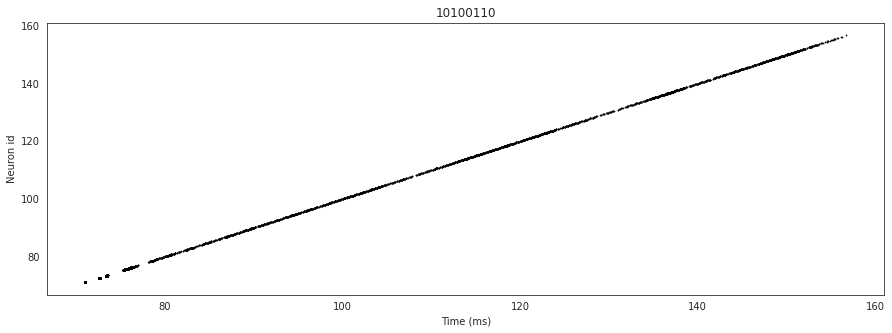

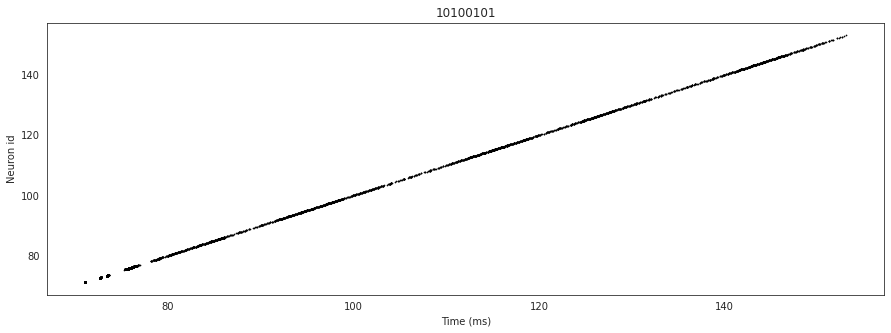

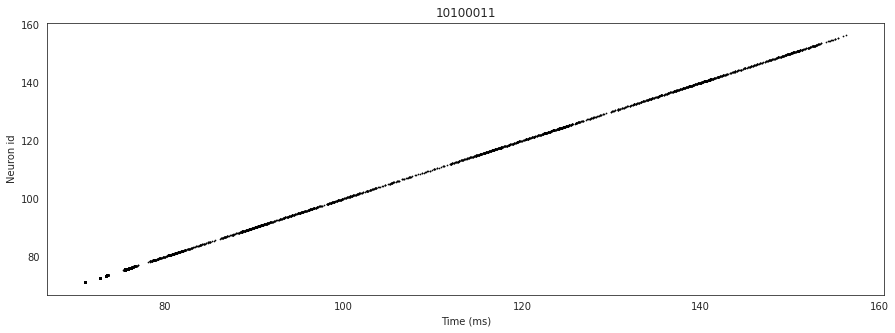

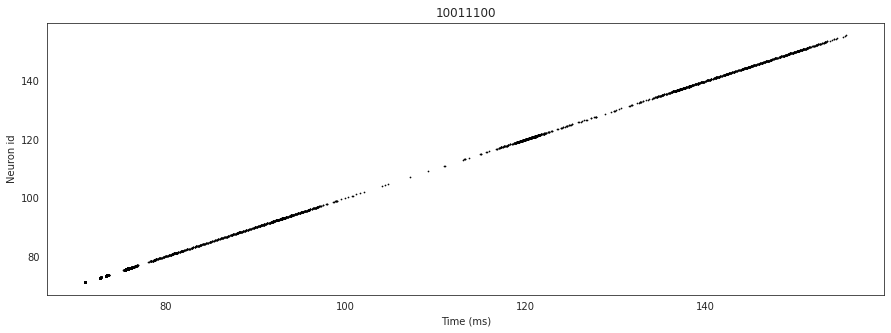

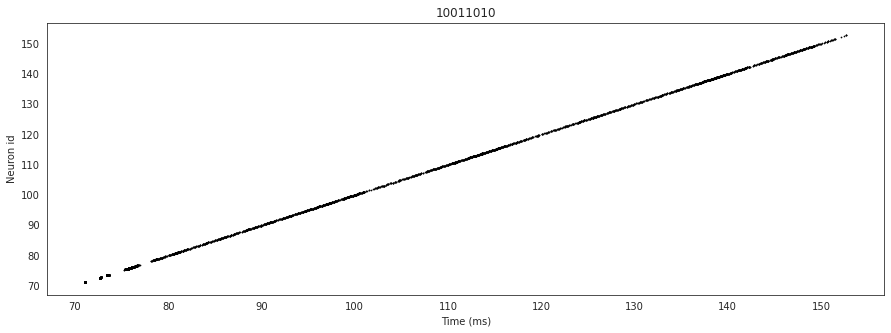

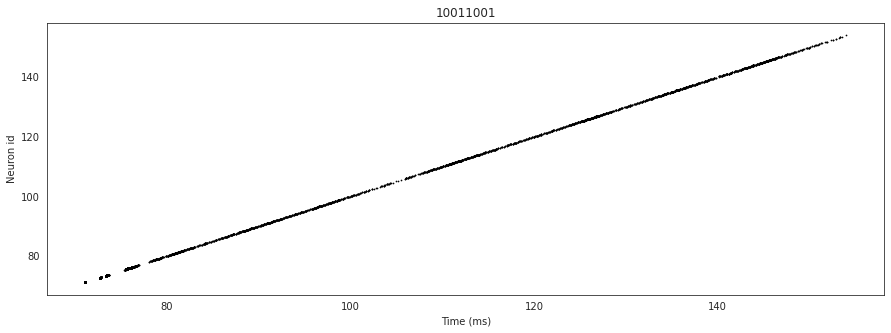

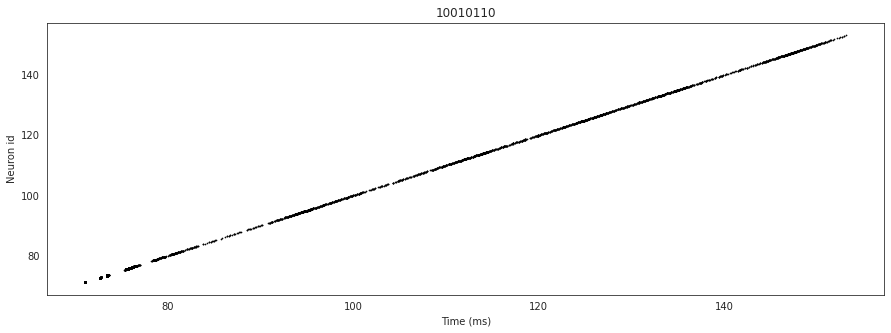

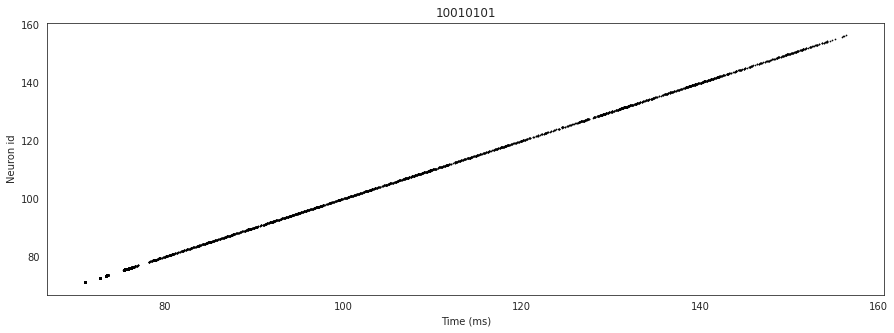

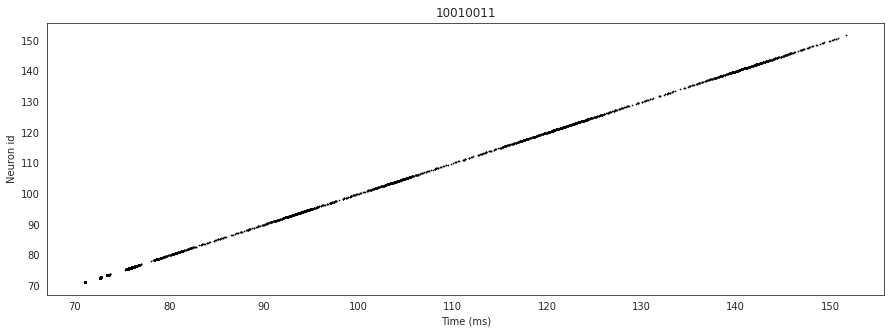

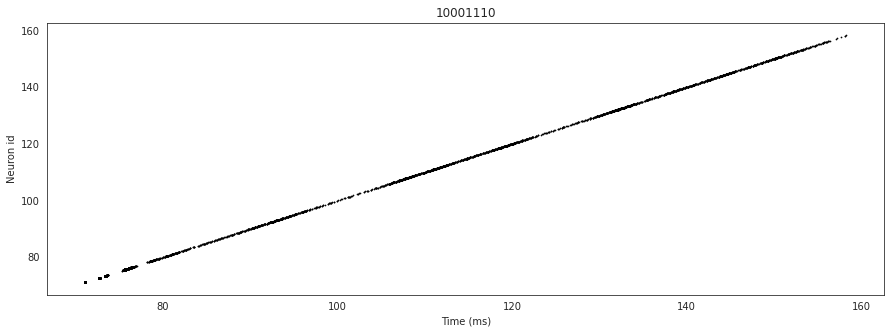

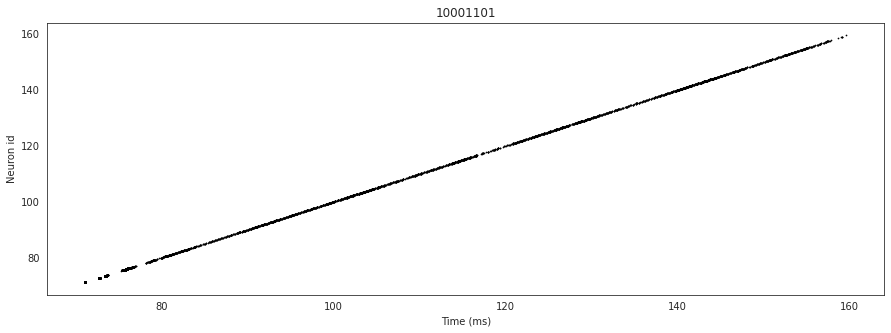

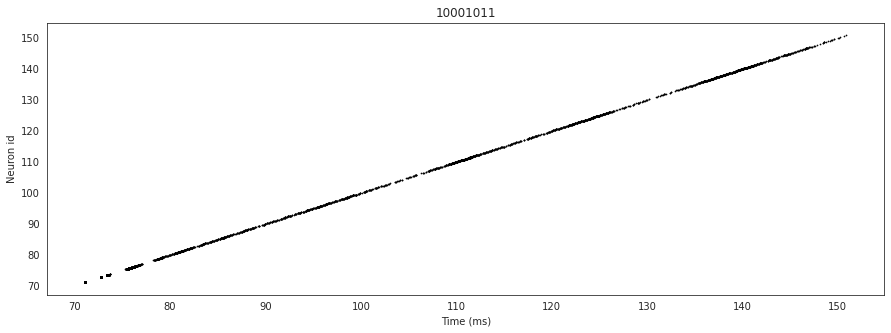

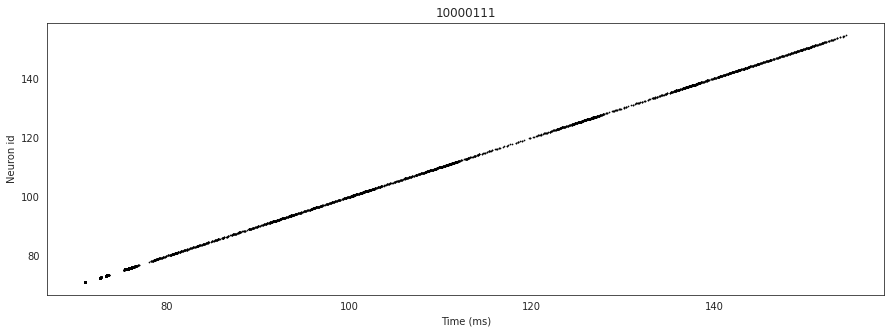

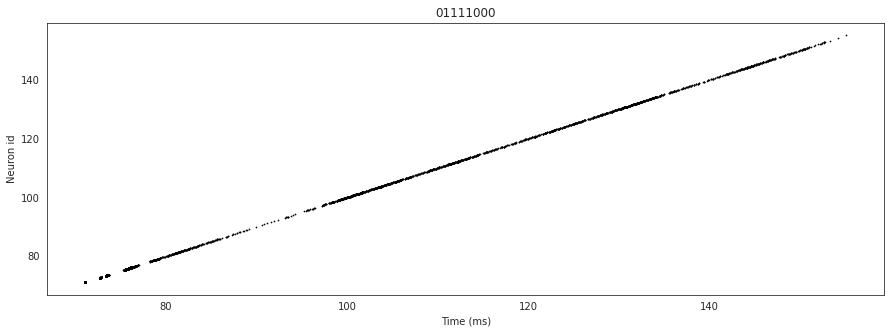

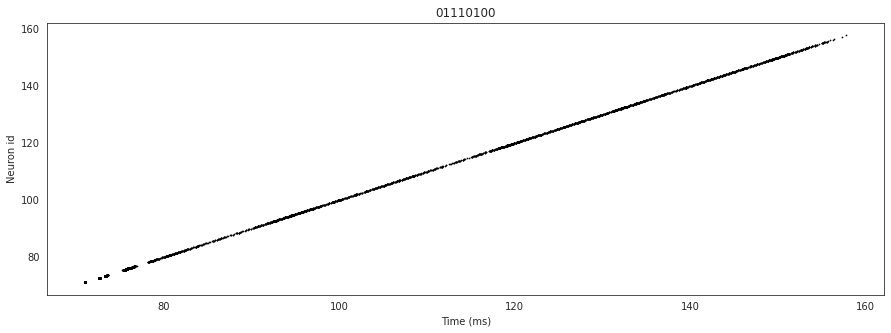

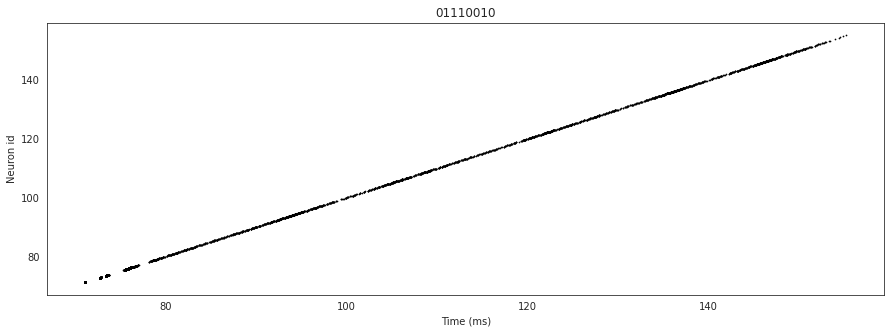

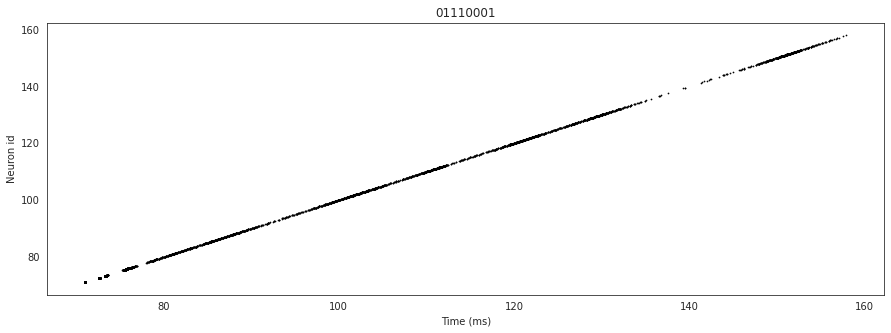

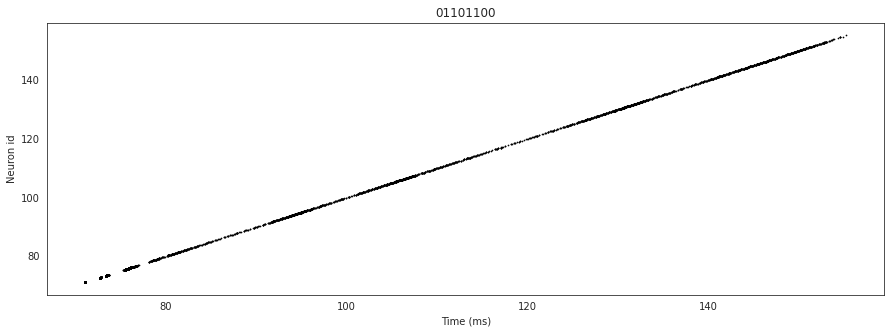

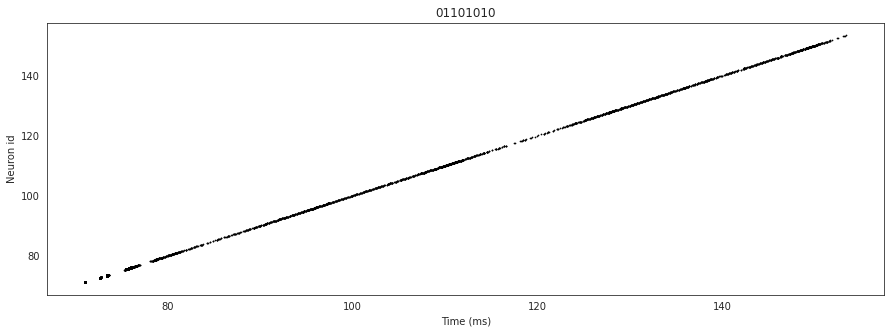

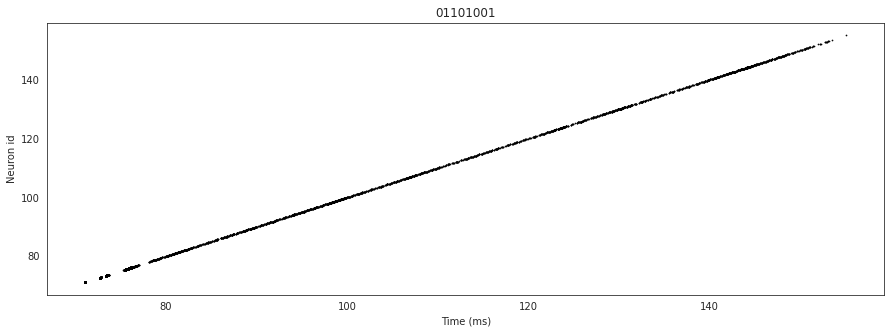

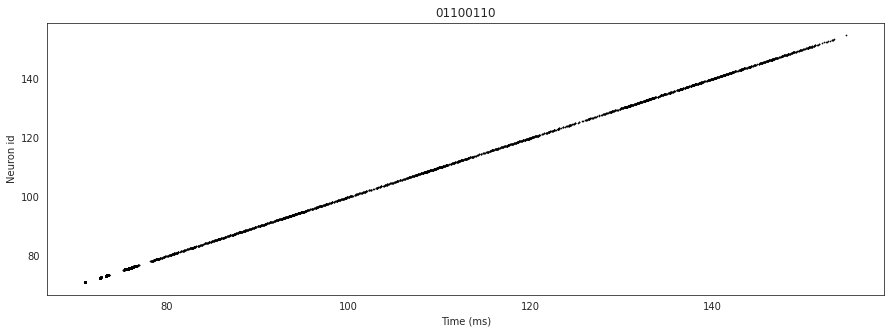

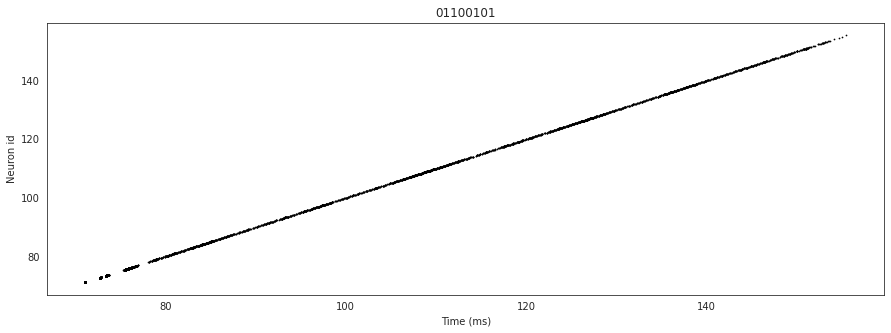

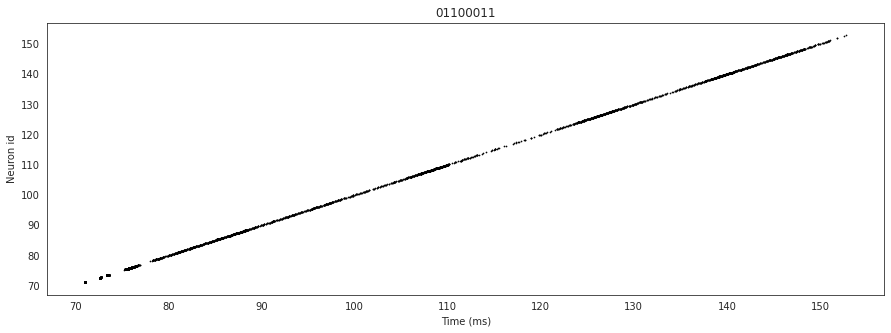

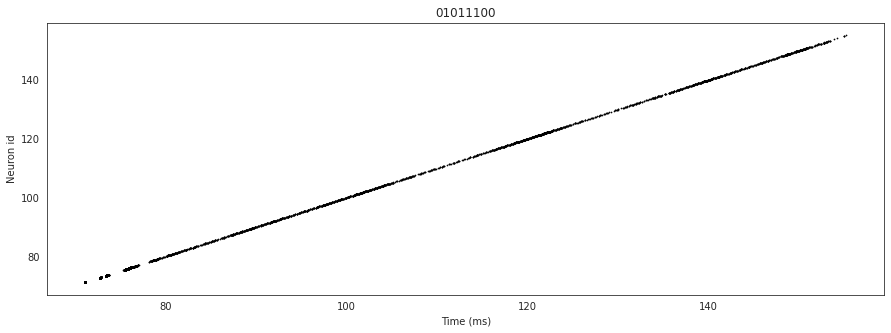

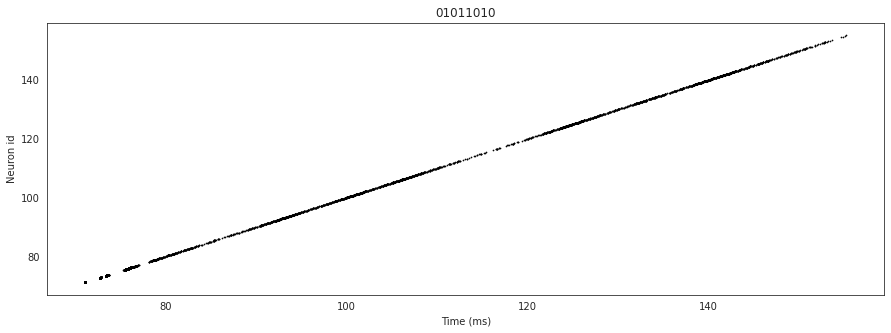

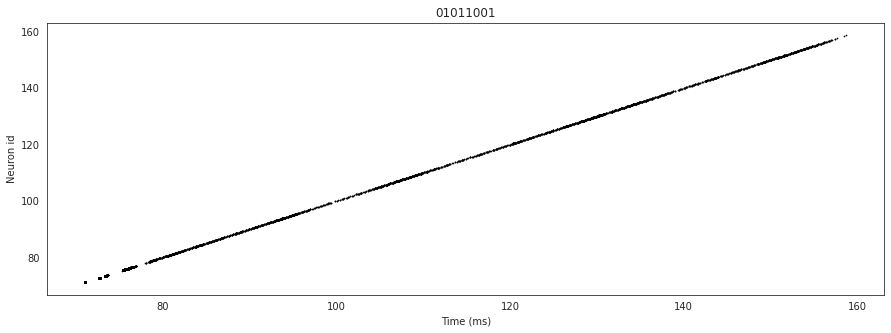

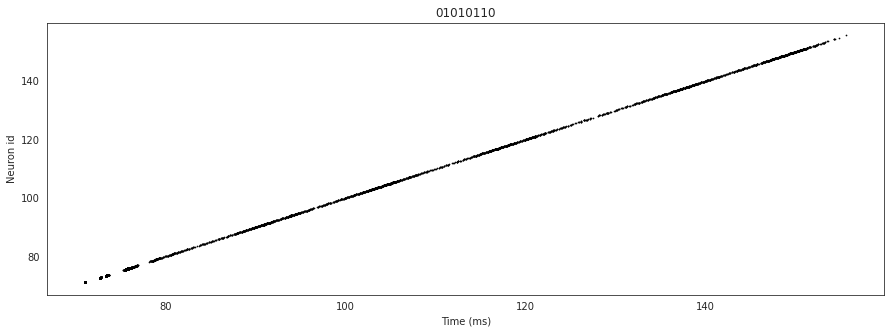

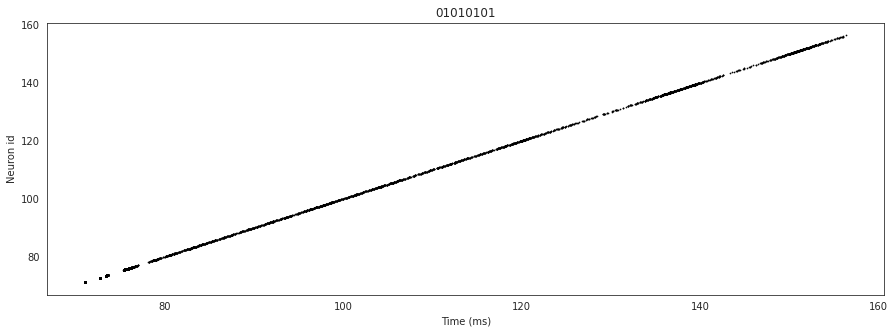

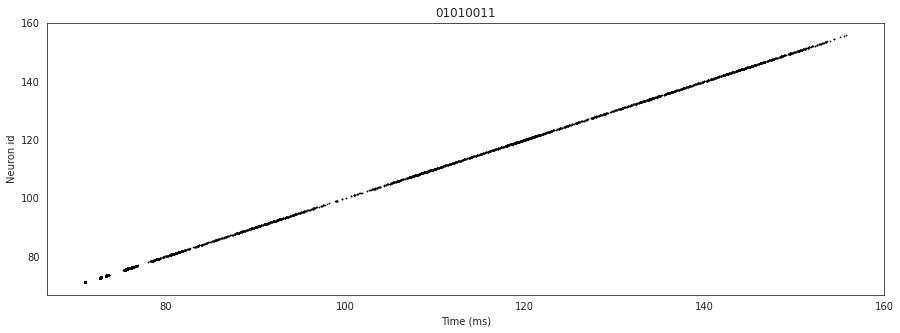

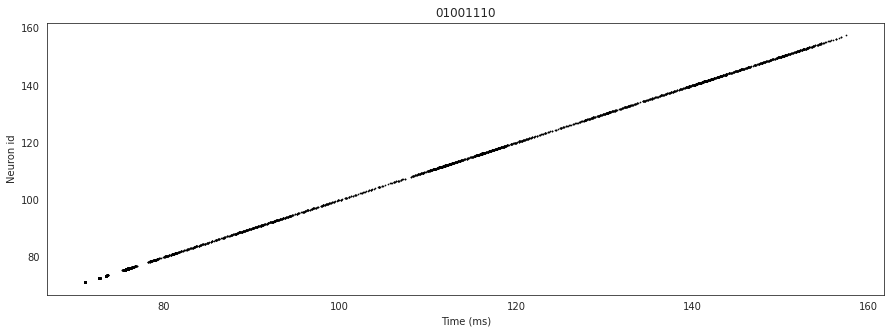

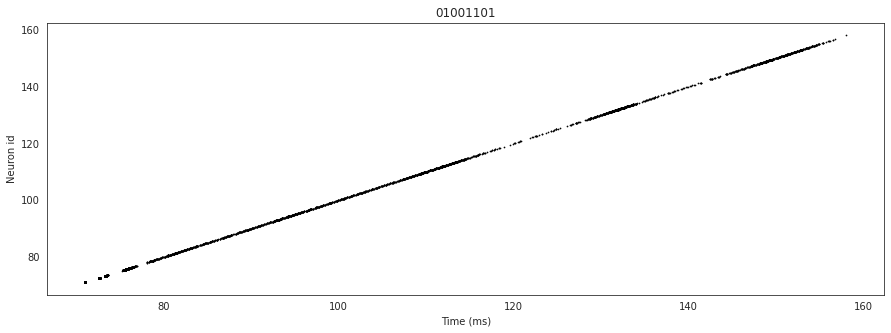

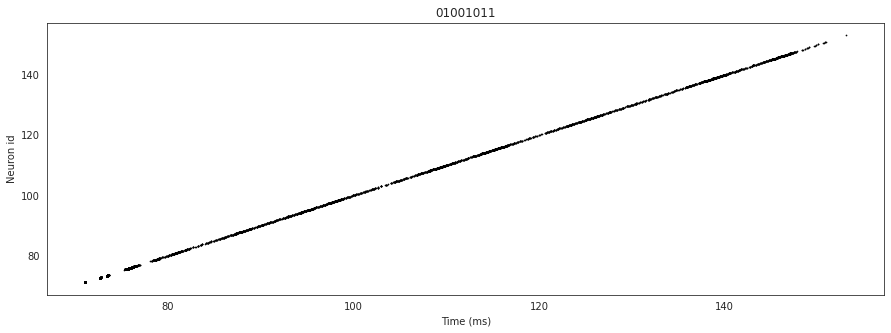

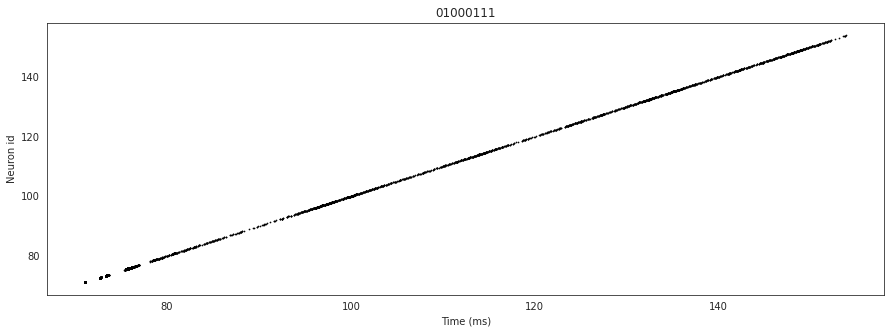

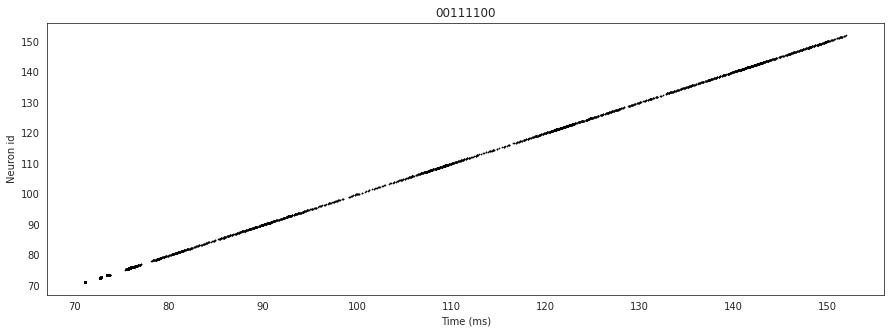

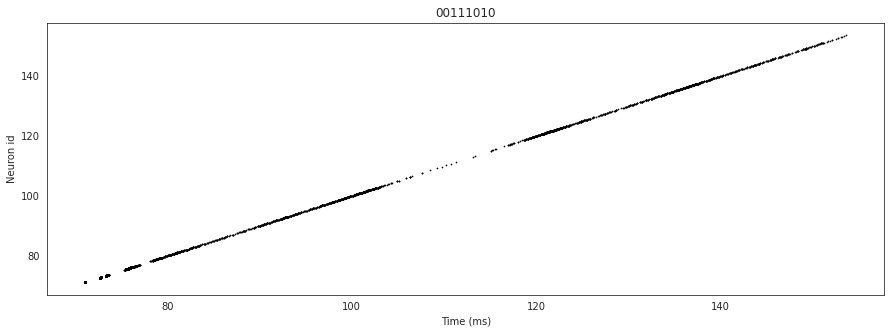

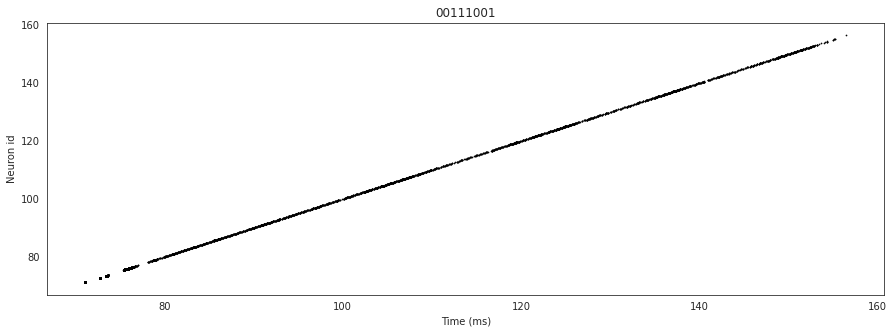

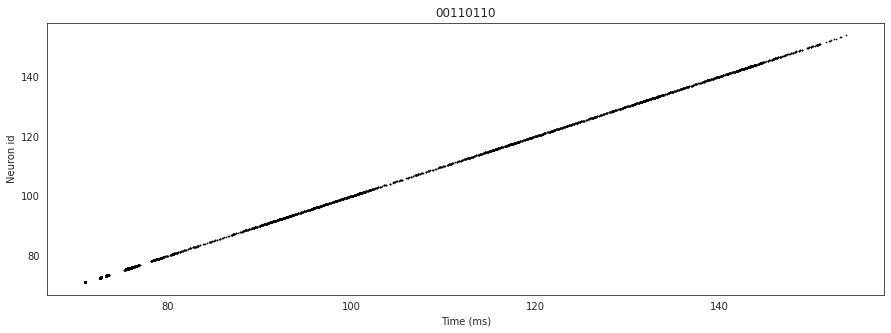

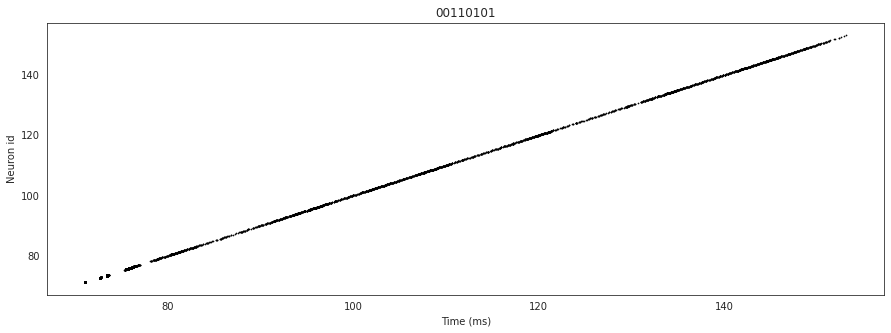

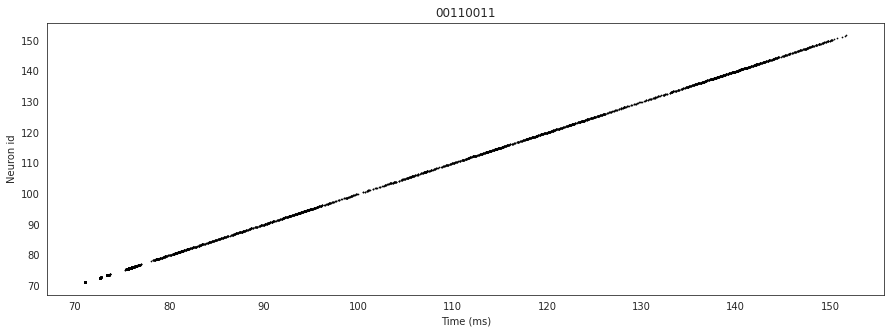

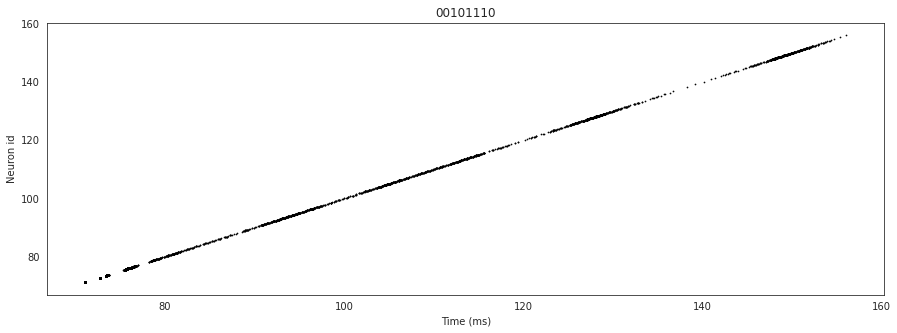

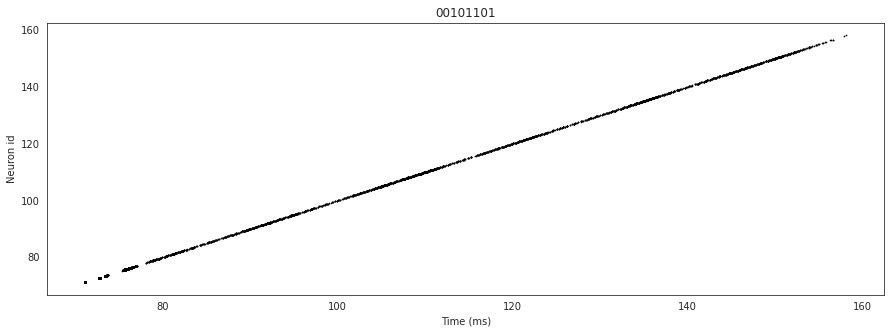

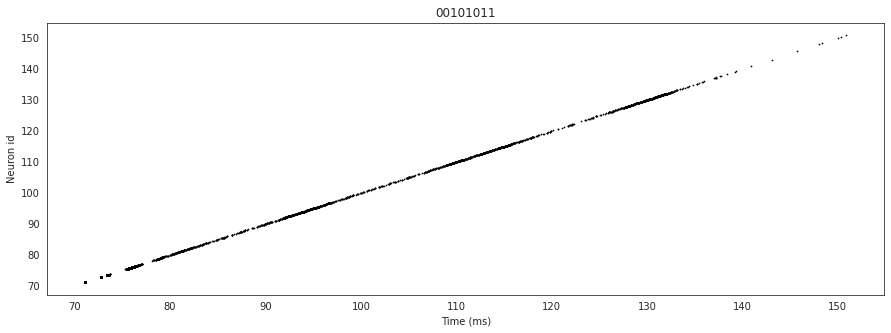

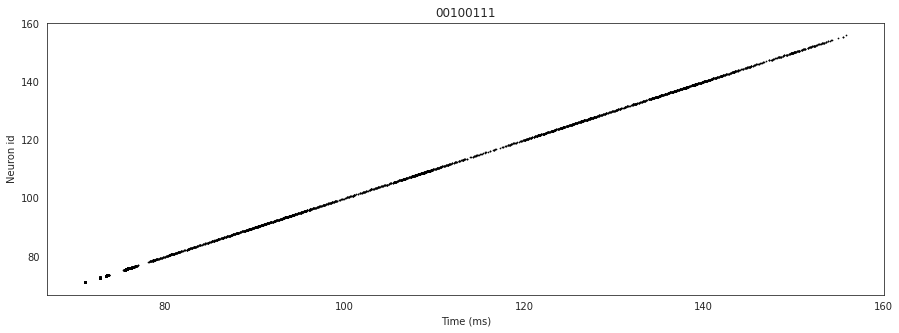

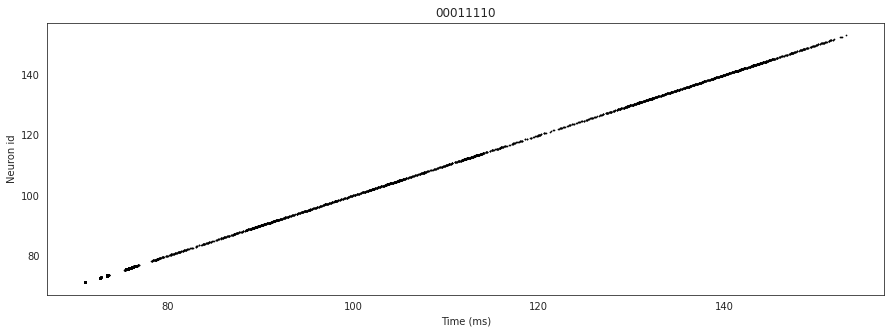

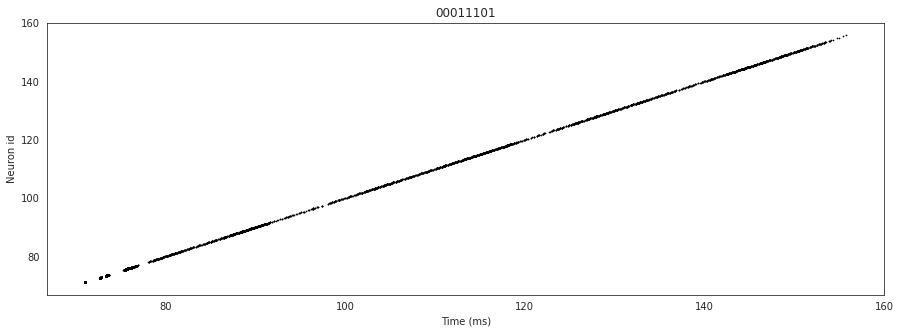

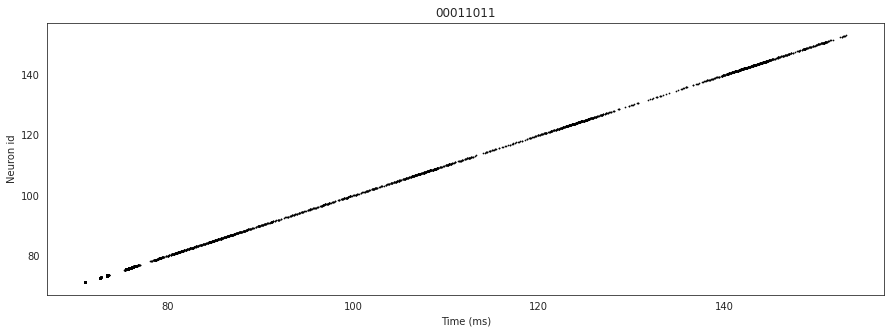

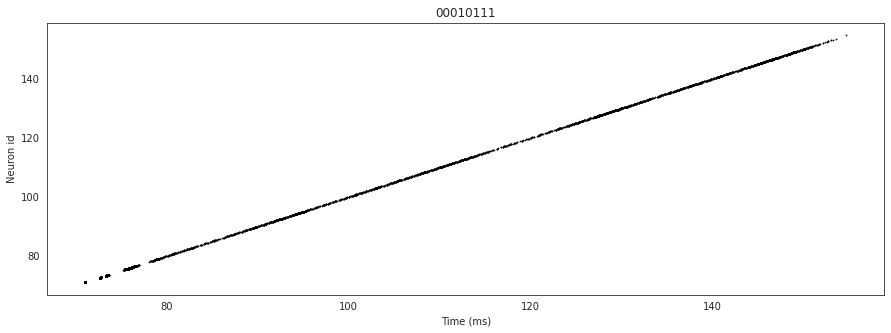

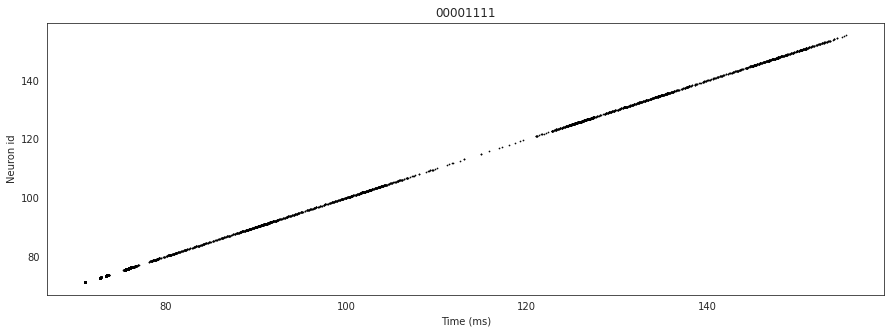

In [240]:
for i, pattern in enumerate(patterns):
    f = plt.figure(figsize=(15,5))
    plt.title(H.list2str(patterns[i]))
    plt.scatter(spike_times_arr[i], spike_neurons_arr[i], marker='o', s=0.5, color='k');
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron id');